# Preparing the data

In [1]:
%cd /home/shuaman/repucs/PSL-GAN
%load_ext autoreload
%autoreload 2

/home/shuaman/repucs/PSL-GAN


In [2]:
from platform import python_version

print(python_version())

3.8.11


In [3]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')
import warnings
warnings.filterwarnings("ignore")
import missingno as msno

In [4]:
from utils.utils_getdata import *
from create_dataset import *

In [5]:
pd.options.display.max_columns = 300

In [6]:
width_frames = height_frames = 256

In [7]:
path_data = "/data/shuaman/psl_gan/Data/landmarks"

name_aec_mp = "AEC--mediapipe.pk"
name_aec_wp = "AEC--wholepose.pk"
name_pucp_mp = "PUCP_PSL_DGI156--mediapipe.pk"
name_pucp_wp = "PUCP_PSL_DGI156--wholepose.pk"

In [8]:
df_aec_mp = pd.read_pickle(os.path.join(path_data, name_aec_mp)).T
print(df_aec_mp.shape)
df_aec_mp.head(2)

(2310, 3)


,data,label,name
0,[[{'pose': [[0.47449803 0.18475646] [0.487047...,sí,sí_634.mp4
1,[[{'pose': [[0.45426351 0.20800602] [0.486233...,acuerdo,acuerdo_201.mp4


In [9]:
df_aec_wp = pd.read_pickle(os.path.join(path_data, name_aec_wp)).T
print(df_aec_mp.shape)
df_aec_wp.head(2)

(2310, 3)


,data,label,name
0,"[[[[0.47265625 0.17578125], [0.49609375 0.1523...",sí,sí_634.mp4
1,"[[[[0.43359375 0.19921875], [0.48046875 0.1679...",acuerdo,acuerdo_201.mp4


In [10]:
assert df_aec_mp.shape[0]==df_aec_wp.shape[0] and df_aec_mp[-df_aec_mp.name.isin(df_aec_wp.name.unique())].name.nunique()==0 and df_aec_wp[-df_aec_wp.name.isin(df_aec_mp.name.unique())].name.nunique()==0, "The data is bad, the videos are not the same"

In [11]:
df_pucp_mp = pd.read_pickle(os.path.join(path_data, name_pucp_mp)).T
print(df_pucp_mp.shape)
df_pucp_mp.head(2)

(3684, 3)


,data,label,name
0,[[{'pose': [[0.46785569 0.27530617] [0.492731...,CERRAR-CORTINA,CERRAR-CORTINA_1655.mp4
1,[[{'pose': [[0.50296938 0.28941905] [0.527952...,S-U-E,S-U-E_1653.mp4


In [12]:
df_pucp_wp = pd.read_pickle(os.path.join(path_data, name_pucp_wp)).T
print(df_pucp_wp.shape)
df_pucp_wp.head(2)

(3684, 3)


,data,label,name
0,"[[[[0.44140625 0.25390625], [0.48828125 0.2226...",CERRAR-CORTINA,CERRAR-CORTINA_1655.mp4
1,"[[[[0.48046875 0.26953125], [0.51953125 0.2304...",S-U-E,S-U-E_1653.mp4


In [13]:
assert df_pucp_mp.shape[0]==df_pucp_wp.shape[0] and df_pucp_mp[-df_pucp_mp.name.isin(df_pucp_wp.name.unique())].name.nunique()==0 and df_pucp_wp[-df_pucp_wp.name.isin(df_pucp_mp.name.unique())].name.nunique()==0, "The data is bad, the videos are not the same"

In [14]:
import itertools
import sys

In [15]:
print(len(df_aec_wp.name.unique()))
for videoname in df_aec_wp.name.unique():
    data_video = df_aec_wp.loc[df_aec_wp.name==videoname].data.values[0][0]
    print(len(data_video))
    for n_frame, data_frame in enumerate(data_video):
        print(len(data_frame))
        for pos, landmark in enumerate(data_frame):
            print(len(landmark))
            break
        #for 
        break
    break

2310
8
133
2


In [16]:
def process_raw_data(df_in,
                     width_frames,
                     height_frames,
                    type_lm: str="MP"):
    df = df_in.copy()
    
    assert df.shape[0]==df.name.nunique(), "There are repeated videnames"
    
    list_videoname = []
    list_frames = []
    list_X = []
    list_Y = []
    list_pos = []
    list_label = []
    
    for videoname in df.name.unique():
        label = df.loc[df.name==videoname].label.values[0]
        data_video = df.loc[df.name==videoname].data.values[0][0]
        for n_frame, data_frame in enumerate(data_video):
            if type_lm=="MP":
                landmarks = []
                for body_location in data_frame.keys():
                    landmarks.append(data_frame[body_location])
                landmarks = list(itertools.chain(*landmarks))
            elif type_lm=="WP":
                landmarks = data_frame
            else:
                print("This is not a valid landmark type")
                sys.exit(0)
            for pos,landmark in enumerate(landmarks):
                list_X.append(landmark[0])
                list_Y.append(landmark[1])
                list_pos.append(pos)
                list_frames.append(n_frame)
                list_videoname.append(videoname)
                list_label.append(label)
                    
    
    data = {
            "videoname": list_videoname,
            "n_frame": list_frames,
            "n_landmark": list_pos,
            "x": list_X,
            "y": list_Y,
            "class": list_label
        }
    
    df = pd.DataFrame(data) 

    print(f"{df.shape=}")
    print(f"{df.videoname.nunique()=}")

    df['out_range?'] = (df['x']<=0) | (df['y']<=0) | (df['x']*width_frames>=width_frames) | (df['y']*height_frames>=height_frames)
    
    df_corr = df.loc[(df['out_range?']==False) &
                    (df['class']!="???"), :].reset_index(drop=True)
    

    print(f"{df_corr.shape=}")
    print(f"{df_corr.videoname.nunique()=}")
    
    return df, df_corr
    

In [17]:
def get_process_data(path_or, path_or_corr, df_mp, type_lm,
                      width_frames,
                     height_frames,
                     read_backup=True):
    if read_backup and os.path.exists(path_or) and os.path.exists(path_or_corr):
        print("Reading backup")
        df_mp_or = pd.read_csv(path_or)
        df_mp_or_corr = pd.read_csv(path_or_corr)
        
        print(f"{df_mp_or.shape=}")
        print(f"{df_mp_or.videoname.nunique()=}")
        print(f"{df_mp_or_corr.shape=}")
        print(f"{df_mp_or_corr.videoname.nunique()=}")
    
    else:
        print("Generating from scratch")
        df_mp_or, df_mp_or_corr  = process_raw_data(df_mp, width_frames, height_frames, type_lm)
        print("Saving to backup")
        df_mp_or.to_csv(path_or, header=True, index=False)
        df_mp_or_corr.to_csv(path_or_corr, header=True, index=False)
    

    
    return df_mp_or, df_mp_or_corr

In [18]:
path_aec_mp_or = os.path.join(path_data, "df_aec_mp_or.csv")
path_aec_mp_or_corr = os.path.join(path_data, "df_aec_mp_or_corr.csv")

df_aec_mp_or, df_aec_mp_or_corr  = get_process_data(path_aec_mp_or, path_aec_mp_or_corr, 
                                                    df_aec_mp, type_lm="MP",
                                                     width_frames=width_frames,
                                                     height_frames=height_frames,
                                                    read_backup=True)

Generating from scratch
df.shape=(18753591, 6)
df.videoname.nunique()=2310
df_corr.shape=(17842890, 7)
df_corr.videoname.nunique()=2287
Saving to backup


In [19]:
path_pucp_mp_or = os.path.join(path_data, "df_pucp_mp_or.csv")
path_pucp_mp_or_corr = os.path.join(path_data, "df_pucp_mp_or_corr.csv")

df_pucp_mp_or, df_pucp_mp_or_corr  = get_process_data(path_pucp_mp_or, path_pucp_mp_or_corr, 
                                                      df_pucp_mp, type_lm="MP",
                                                      width_frames=width_frames,
                                                     height_frames=height_frames,
                                                    read_backup=True)

Generating from scratch
df.shape=(39724794, 6)
df.videoname.nunique()=3684
df_corr.shape=(37172796, 7)
df_corr.videoname.nunique()=3682
Saving to backup


In [20]:
path_aec_wp_or = os.path.join(path_data, "df_aec_wp_or.csv")
path_aec_wp_or_corr = os.path.join(path_data, "df_aec_wp_or_corr.csv")

df_aec_wp_or, df_aec_wp_or_corr  = get_process_data(path_aec_wp_or, path_aec_wp_or_corr, 
                                                    df_aec_wp, type_lm="WP",
                                                    width_frames=width_frames,
                                                     height_frames=height_frames,
                                                    read_backup=True)

Generating from scratch
df.shape=(4593421, 6)
df.videoname.nunique()=2310
df_corr.shape=(4533052, 7)
df_corr.videoname.nunique()=2287
Saving to backup


In [19]:
df_aec_wp_or.head(1)

,videoname,n_frame,n_landmark,x,y,class,out_range?
0,sí_634.mp4,0,0,0.472656,0.175781,sí,False


In [56]:
df_pucp_mp_or_corr.y.min()

1.6294419765472412e-05

In [57]:
df_pucp_mp_or_corr.y.max()

0.9999996423721313

In [172]:
def matrix_plot(df_flag_lm_orig, 
                list_landmarks_mp, 
                dict_rename_columns,
                dataset,
                type_lm,
                out_path
               ):
    
    name_file = f"matrixplot-{type_lm}-{dataset}.png"
    path = os.path.join(out_path, name_file)
    
    #plt.figure(figsize=(20,40))
    msno.matrix(df_flag_lm_orig[list_landmarks_mp].rename(columns=dict_rename_columns),
               figsize=(60, 20), label_rotation=25) 
    plt.title(f"MatrixPlot - Missing Values {type_lm} - {dataset} Dataset", fontdict={"fontsize": 20})
    plt.xlabel("Pose Landmark")
    #plt.ylabel("")

    plt.savefig(path)
    plt.show()
    

def heatmap_plot(df_flag_lm_orig, 
                    list_landmarks_mp, 
                    dict_rename_columns,
                    dataset,
                    type_lm,
                 out_path
                ):
    
    name_file = f"heatmap-{type_lm}-{dataset}.png"
    path = os.path.join(out_path, name_file)
    
    #plt.figure(figsize=(20,25))
    msno.heatmap(df_flag_lm_orig[list_landmarks_mp].rename(columns=dict_rename_columns))
    plt.title(f"Heatmap - Missing Values {type_lm} - {dataset} Dataset", fontdict={"fontsize": 20})
    plt.xlabel("Pose Landmark")
    plt.ylabel("Pose Landmark")

    plt.savefig(path)
    plt.show()


def dendogram_plot(df_flag_lm_orig, 
                    list_landmarks_mp, 
                    dict_rename_columns,
                    dataset,
                    type_lm,
                   out_path
                  ):
    name_file = f"dendogram-{type_lm}-{dataset}.png"
    path = os.path.join(out_path, name_file)

    #plt.figure(figsize=(20,25))
    msno.dendrogram(df_flag_lm_orig[list_landmarks_mp].rename(columns=dict_rename_columns),
                   figsize=(60, 20), label_rotation=25)
    plt.title(f"Dendogram - Missing Values {type_lm} - {dataset} Dataset", fontdict={"fontsize": 20})
    #plt.xlabel("Pose Landmark")
    #plt.ylabel("Pose Landmark")

    plt.savefig(path)
    plt.show()

def plot_missing_values_lm(df_flag_lm_orig, 
                              list_landmarks_mp,
                              dict_rename_columns,
                               dataset,
                               type_lm,
                           out_path
                              ):
    
    matrix_plot(df_flag_lm_orig, 
                    list_landmarks_mp, 
                    dict_rename_columns,
                    dataset,
                    type_lm,
                out_path
                   )
    heatmap_plot(df_flag_lm_orig, 
                list_landmarks_mp, 
                dict_rename_columns,
                dataset,
                type_lm,
                 out_path
                )
    dendogram_plot(df_flag_lm_orig, 
                    list_landmarks_mp, 
                    dict_rename_columns,
                    dataset,
                    type_lm,
                   out_path
                  )
    
def plot_all_missing_values_images(df_or,
                                  df_flag_lm_orig,
                                  df_flag_lm,
                                  list_landmarks_mp,
                                  list_landmarks_coco_converted,
                                  dict_rename_columns,
                                  dict_wp_rename_columns,
                                  dataset,
                                  out_path="out"
                                 ):
    
    if not os.path.exists(out_path):
        os.mkdir(out_path)
    
    name_file_hist = f"histogram_ninstances-{dataset}.png"
    path = os.path.join(out_path, name_file_hist)
    
    sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})
    # sns.set_theme()
    #plt.figure(figsize=(10,6), tight_layout=True)
    plt.title(f"Histogram - Instances per unique sign - {dataset} Dataset")
    plt.xlabel("Number of instances")
    plt.ylabel("Frequency")
    sns.histplot(data=df_or.groupby(["class"]).videoname.nunique().reset_index(), x="videoname", kde=True, bins=15,
                    )
    plt.savefig(path)
    plt.show()

    
    plot_missing_values_lm(df_flag_lm_orig, 
                              list_landmarks_mp,
                              dict_rename_columns,
                               dataset,
                               type_lm="MediaPipe",
                           out_path=out_path
                              )
    plot_missing_values_lm(df_flag_lm_orig, 
                              list_landmarks_coco_converted,
                              dict_wp_rename_columns,
                               dataset,
                               type_lm="WholePose",
                           out_path=out_path
                              )
    
    name_file_fplot = f"comparison-mp-wp-{dataset}.png"
    path = os.path.join(out_path, name_file_fplot)
    
    df_notna_lm = pd.concat([df_flag_lm_orig[list_landmarks_mp].rename(columns=dict_rename_columns).notna().sum(), df_flag_lm_orig[list_landmarks_coco_converted].rename(columns=dict_wp_rename_columns).notna().sum()], axis=1).rename(columns={0: "MediaPipe Landmarks",
                                                                                                                                  1: "WholePose Landmarks"})
    my_range=range(1,len(df_notna_lm.index)+1)
    
    fig = plt.figure(figsize=(16,10), dpi=300)
    plt.plot(my_range, df_notna_lm['MediaPipe Landmarks'], 
                 label="MediaPipe Landmarks", marker="*", color="#5bc0de")
    plt.plot(my_range, df_notna_lm['WholePose Landmarks'], 
             label="WholePose Landmarks", marker="o", color="#E8743B")
    plt.fill_between(my_range, df_notna_lm['MediaPipe Landmarks'], df_notna_lm['WholePose Landmarks'], color="grey", alpha=0.3)
    #plt.legend()
    #plt.xticks(df_notna_lm.index.tolist(), size=13)
    plt.xticks(my_range, df_notna_lm.index.tolist(), rotation=90)
    plt.title(f"Comparison of the number of landmarks - {dataset}", loc='left')
    plt.xlabel("Pose Landmark", fontsize=14)
    plt.ylabel("Number of frames with not null landmarks", fontsize=14)
    plt.legend(fontsize=15)
    plt.savefig(path)
    plt.show()
    
    return df_notna_lm

In [107]:
n_landmarks = 27

In [108]:
LIST_LANDMARKS = LIST_LANDMARKS_dict[str(n_landmarks)]
LIST_LHAND_MEDIAPIPE = LIST_LHAND_MEDIAPIPE_dict[str(n_landmarks)]
LIST_RHAND_MEDIAPIPE = LIST_RHAND_MEDIAPIPE_dict[str(n_landmarks)]
LIST_LANDMARKS_COCO = LIST_LANDMARKS_COCO_dict[str(n_landmarks)]

max_landmark = df_aec_mp_or["n_landmark"].max()

list_landmarks_mp = LIST_LANDMARKS + [i + N_POSE_LANDMARKS for i in LIST_LHAND_MEDIAPIPE]
list_landmarks_mp = list_landmarks_mp + [i + N_POSE_LANDMARKS + N_LHAND_LANDMARKS for i in LIST_RHAND_MEDIAPIPE]
list_landmarks_coco_converted = [i + max_landmark + 1 for i in LIST_LANDMARKS_COCO]
list_landmarks_total = list_landmarks_mp + list_landmarks_coco_converted

In [109]:
dict_rename_columns = {
    0: "nose",
    2: "left_eye",
    5: "right_eye",
    11: "left_shoulder",
    12: "right_shoulder",
    13: "left_elbow",
    14: "right_elbow",
    15: "left_wrist",
    16: "right_wrist",
    21: "left_thumb",
    22: "right_thumb",
    
    38: "left_index_finger_mcp",
    41: "left_index_finger_tip",
    42: "left_middle_finger_mcp",
    45: "left_middle_finger_tip",
    46: "left_ring_finger_mcp",
    49: "left_ring_finger_tip",
    50: "left_pinky_mpc",
    53: "left_pinky_tip",
    
    59: "right_index_finger_mcp",
    62: "right_index_finger_tip",
    63: "right_middle_finger_mcp",
    66: "right_middle_finger_tip",
    67: "right_ring_finger_mcp",
    70: "right_ring_finger_tip",
    71: "right_pinky_mpc",
    74: "right_pinky_tip"
}

In [110]:
dict_wp_rename_columns = {
    0 + max_landmark + 1: "nose",
    1 + max_landmark + 1: "left_eye",
    2 + max_landmark + 1: "right_eye",
    5 + max_landmark + 1: "left_shoulder",
    6 + max_landmark + 1: "right_shoulder",
    7 + max_landmark + 1: "left_elbow",
    8 + max_landmark + 1: "right_elbow",
    9 + max_landmark + 1: "left_wrist",
    10 + max_landmark + 1: "right_wrist",
    95 + max_landmark + 1: "left_thumb",
    116 + max_landmark + 1: "right_thumb",
    
    96 + max_landmark + 1: "left_index_finger_mcp",
    99 + max_landmark + 1: "left_index_finger_tip",
    100 + max_landmark + 1: "left_middle_finger_mcp",
    103 + max_landmark + 1: "left_middle_finger_tip",
    104 + max_landmark + 1: "left_ring_finger_mcp",
    107 + max_landmark + 1: "left_ring_finger_tip",
    108 + max_landmark + 1: "left_pinky_mpc",
    111 + max_landmark + 1: "left_pinky_tip",
    
    117 + max_landmark + 1: "right_index_finger_mcp",
    120 + max_landmark + 1: "right_index_finger_tip",
    121 + max_landmark + 1: "right_middle_finger_mcp",
    124 + max_landmark + 1: "right_middle_finger_tip",
    125 + max_landmark + 1: "right_ring_finger_mcp",
    128 + max_landmark + 1: "right_ring_finger_tip",
    129 + max_landmark + 1: "right_pinky_mpc",
    132 + max_landmark + 1: "right_pinky_tip"
}


# AEC dataset

## Filtering incorrect data

In [37]:
#adding max landmark to wp dataset
df_aec_wp_or_corr["n_landmark"] = df_aec_wp_or_corr["n_landmark"] + max_landmark + 1
df_aec_wp_or_corr.head(10)

,videoname,n_frame,n_landmark,x,y,class,out_range?
0,sí_634.mp4,0,543,0.472656,0.175781,sí,False
1,sí_634.mp4,0,544,0.496094,0.152344,sí,False
2,sí_634.mp4,0,545,0.417969,0.144531,sí,False
3,sí_634.mp4,0,546,0.527344,0.175781,sí,False
4,sí_634.mp4,0,547,0.347656,0.175781,sí,False
5,sí_634.mp4,0,548,0.613281,0.386719,sí,False
6,sí_634.mp4,0,549,0.253906,0.378906,sí,False
7,sí_634.mp4,0,550,0.808594,0.519531,sí,False
8,sí_634.mp4,0,551,0.191406,0.589844,sí,False
9,sí_634.mp4,0,552,0.691406,0.378906,sí,False


In [173]:
df_or = pd.concat([df_aec_mp_or_corr[["videoname", "n_frame", "n_landmark",
                                "x", "y", "class"]],
                  df_aec_wp_or_corr[["videoname", "n_frame", "n_landmark",
                                "x", "y", "class"]]
                  ]).reset_index(drop=True)
print(df_or.shape)
df_or.head()

(22375942, 6)


,videoname,n_frame,n_landmark,x,y,class
0,sí_634.mp4,0,0,0.474498,0.184756,sí
1,sí_634.mp4,0,1,0.487048,0.154266,sí
2,sí_634.mp4,0,2,0.504110,0.155415,sí
3,sí_634.mp4,0,3,0.514052,0.155474,sí
4,sí_634.mp4,0,4,0.442415,0.153642,sí


In [174]:
print()
print("Original")
print(f"Shape {df_or.shape} - N classes", df_or["class"].nunique(), 
    " - Number of videos", df_or["videoname"].nunique())



Original
Shape (22375942, 6) - N classes 505  - Number of videos 2287


## Filtering Landmarks

In [175]:
df_or, df_flag_lm_orig, df_flag_lm, df_flag_lm_v = filter_landmarks(df_or, list_landmarks_mp, list_landmarks_coco_converted, use_coco=True)


Use coco True

Filter: list of landmarks
Shape (920189, 8) - N classes 505  - Number of videos 2287

Filter: frames that have all landmarks
Shape (918378, 8) - N classes 505  - Number of videos 2287

Filter: videos which all frames have those landmarks
Shape (909360, 8) - N classes 500  - Number of videos 2266


## Missing Values Analysis

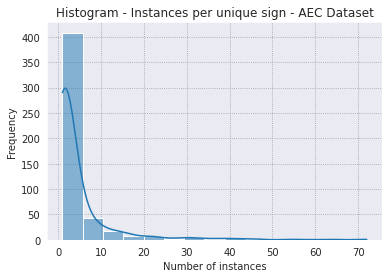

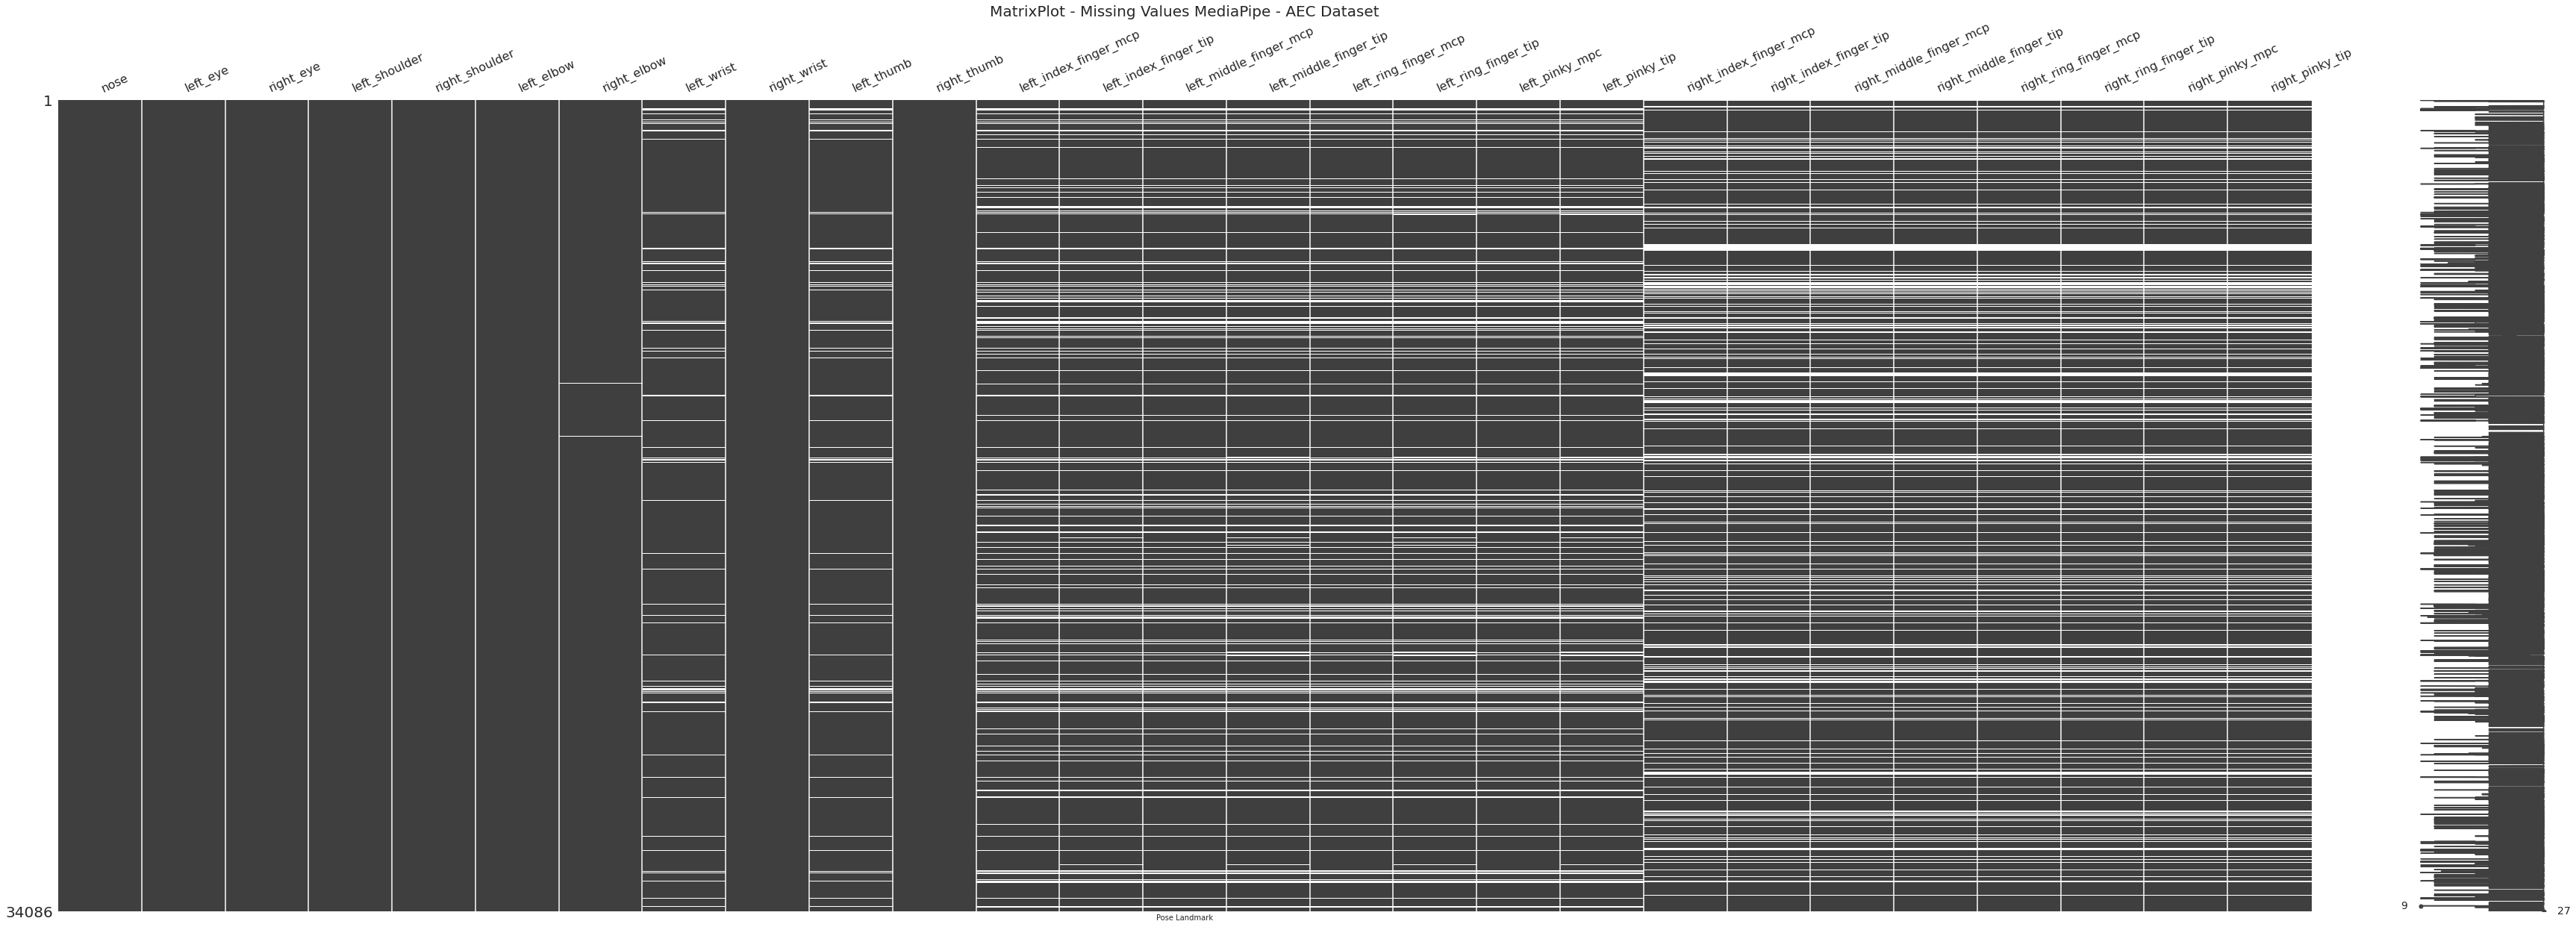

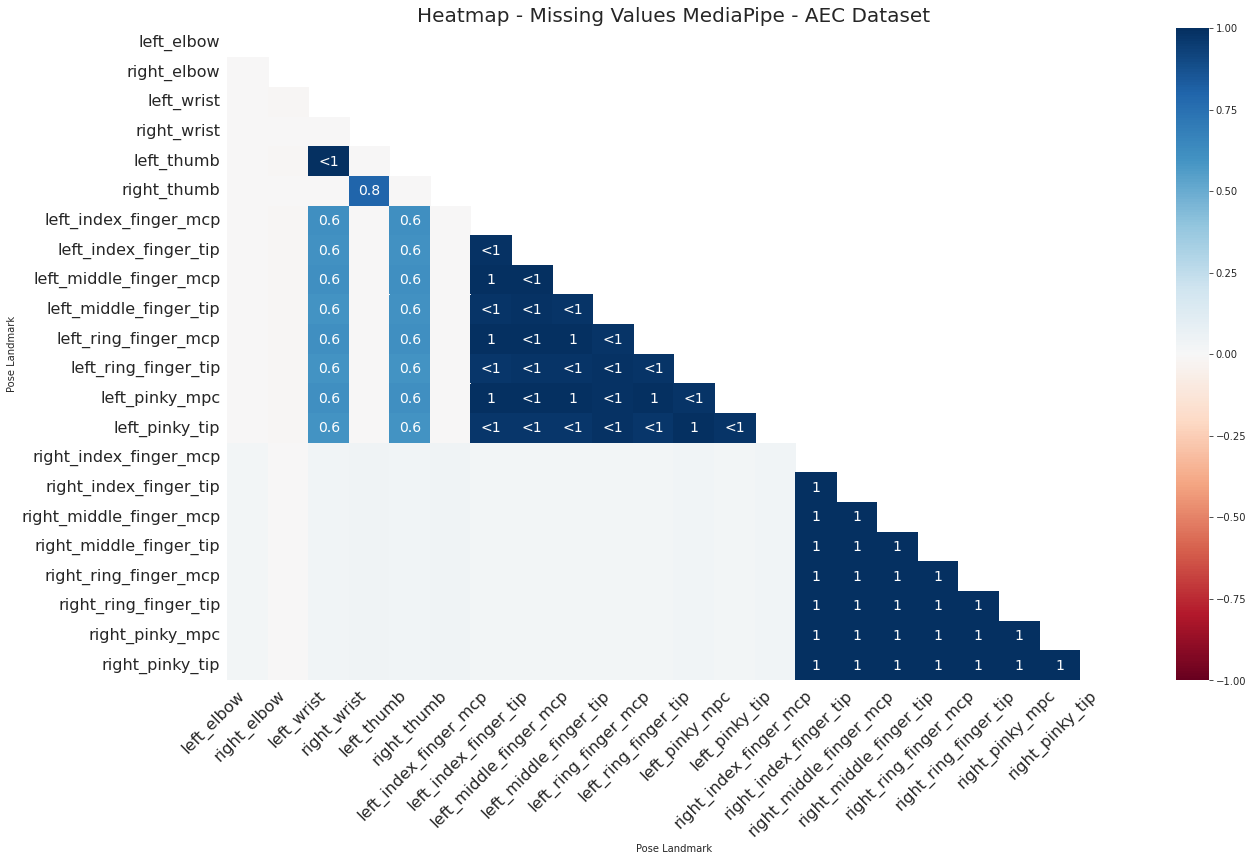

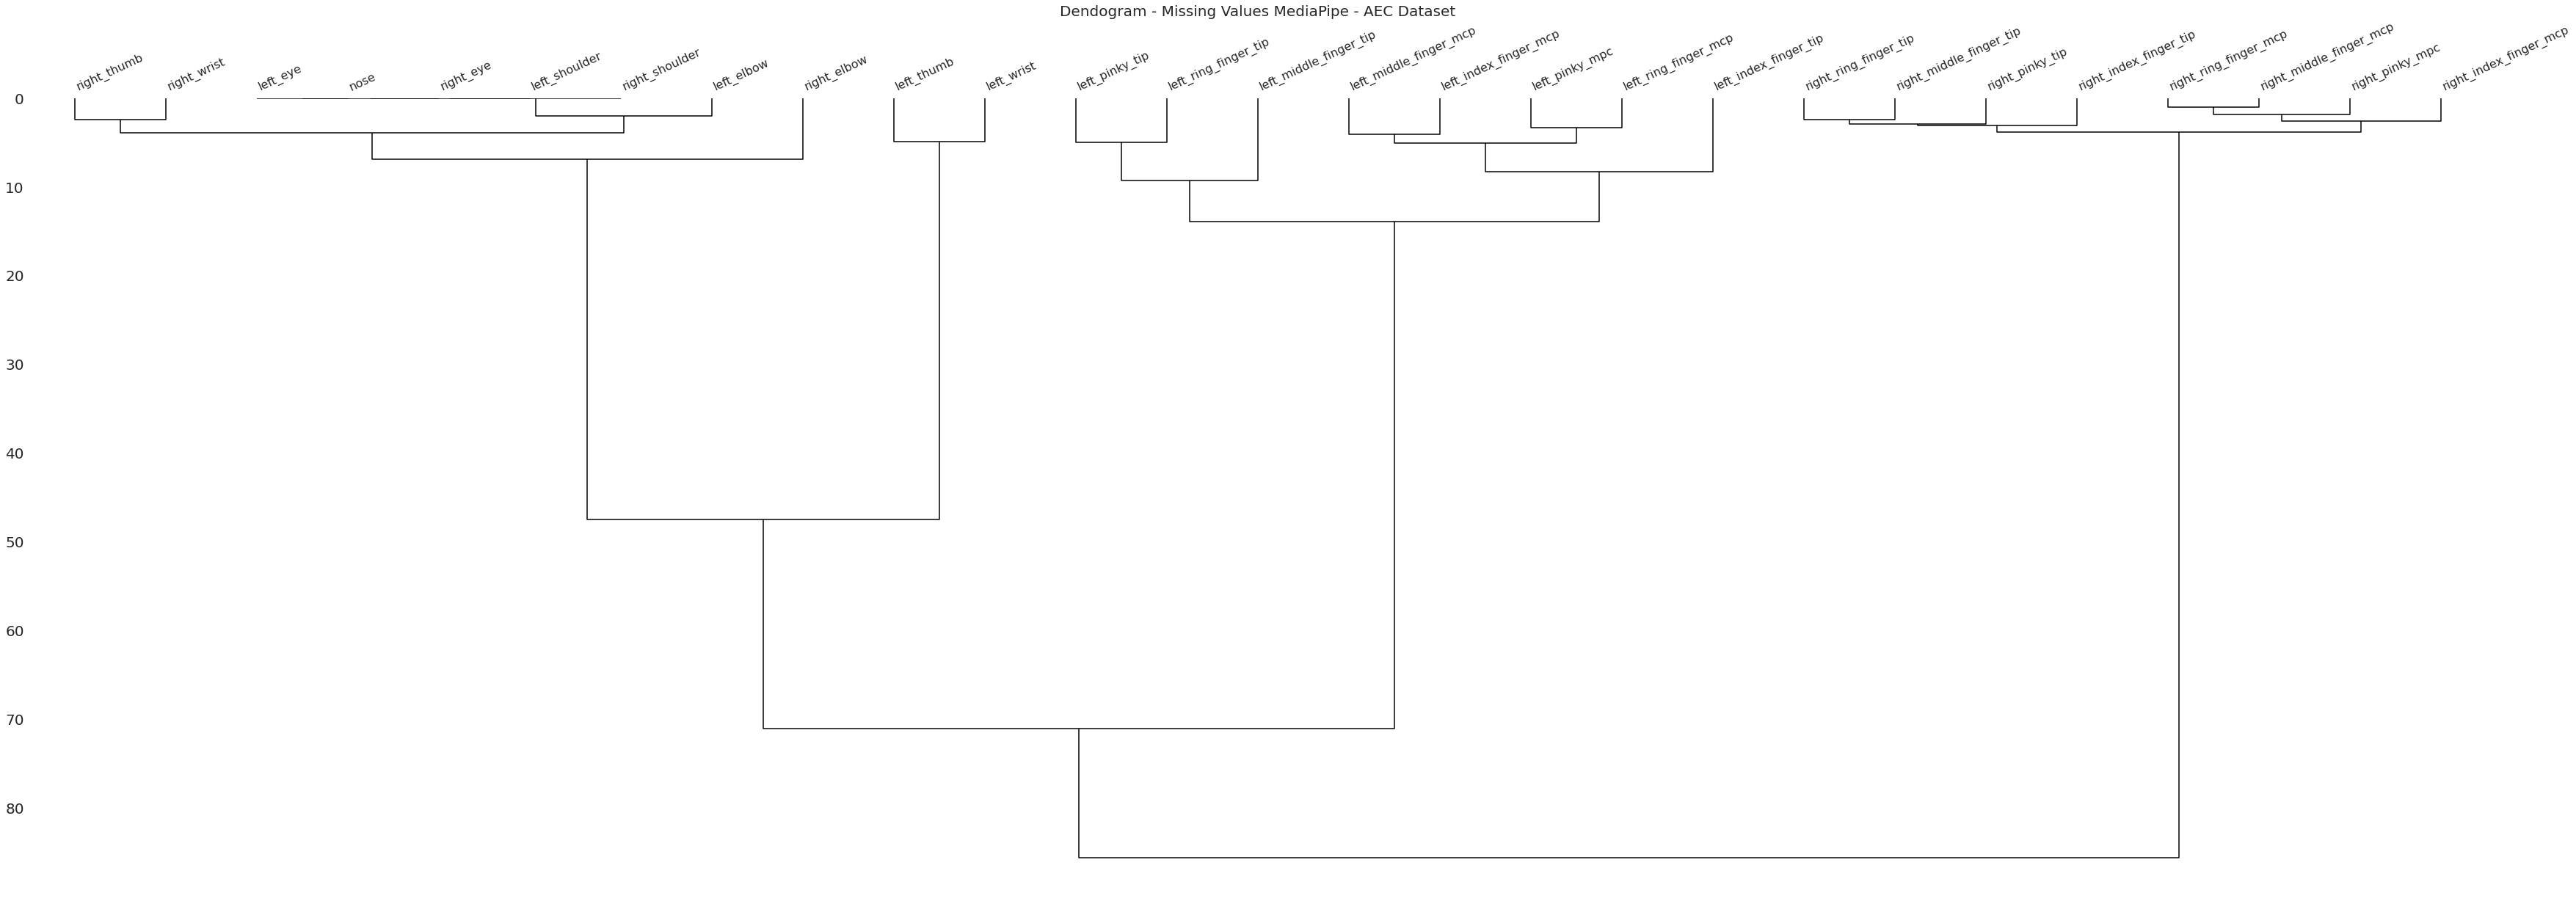

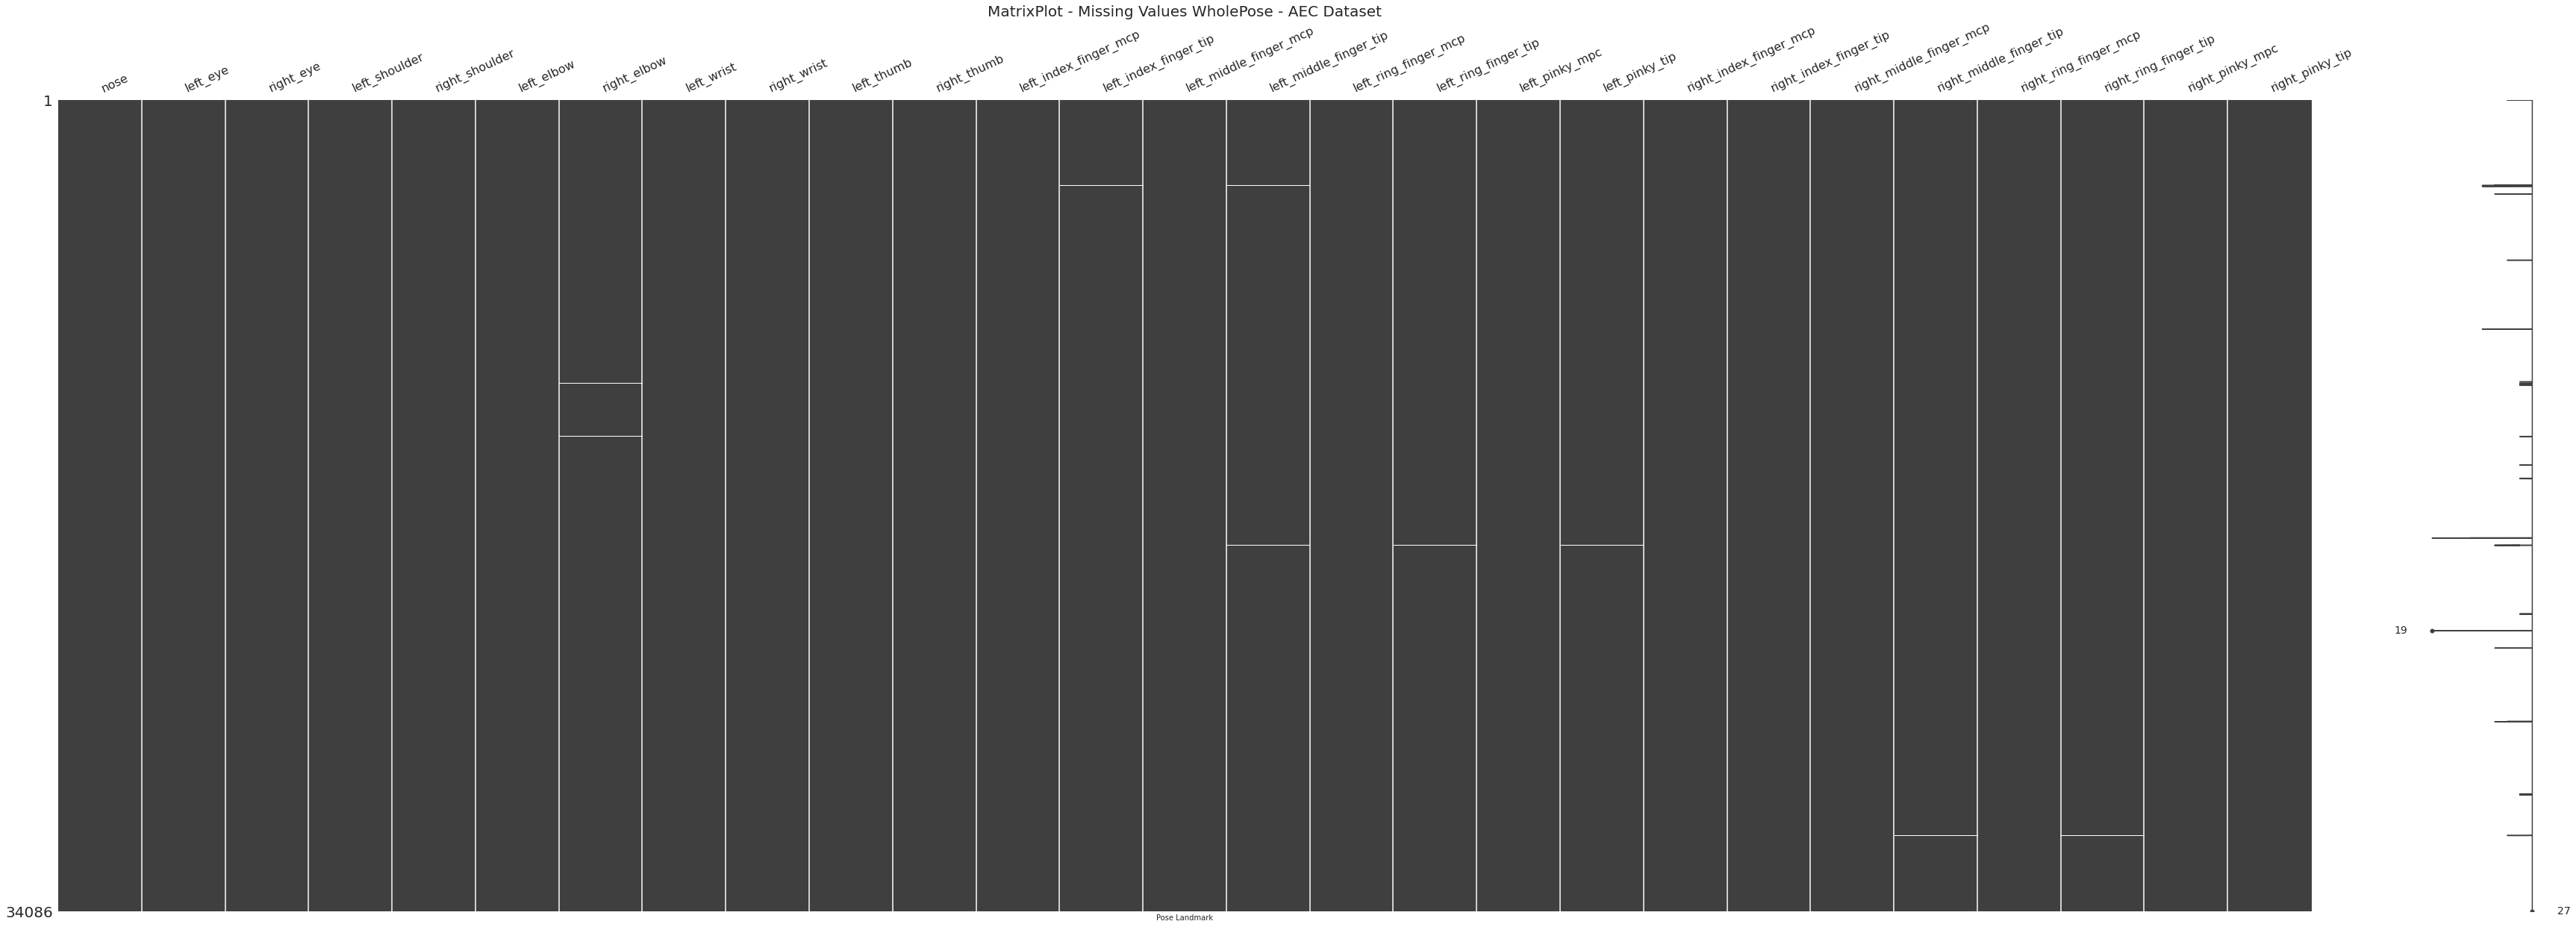

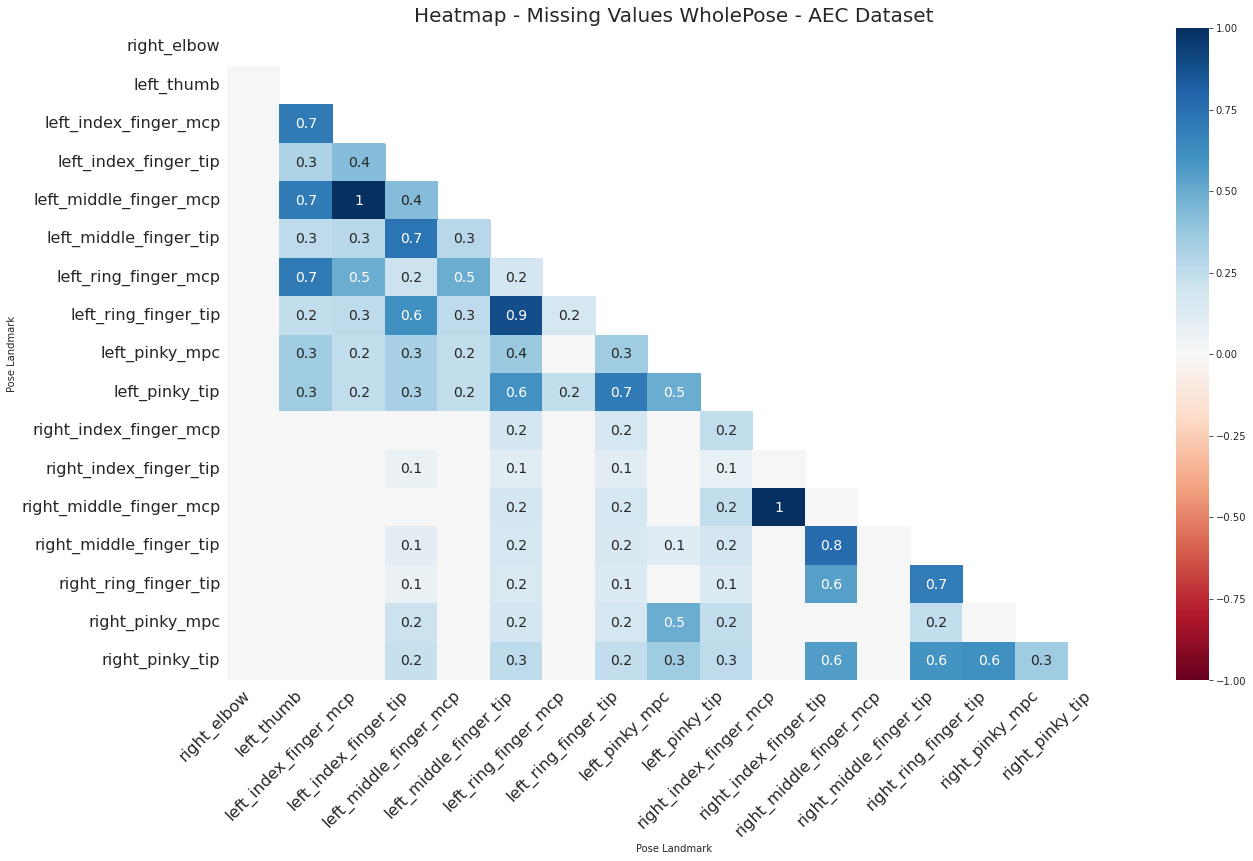

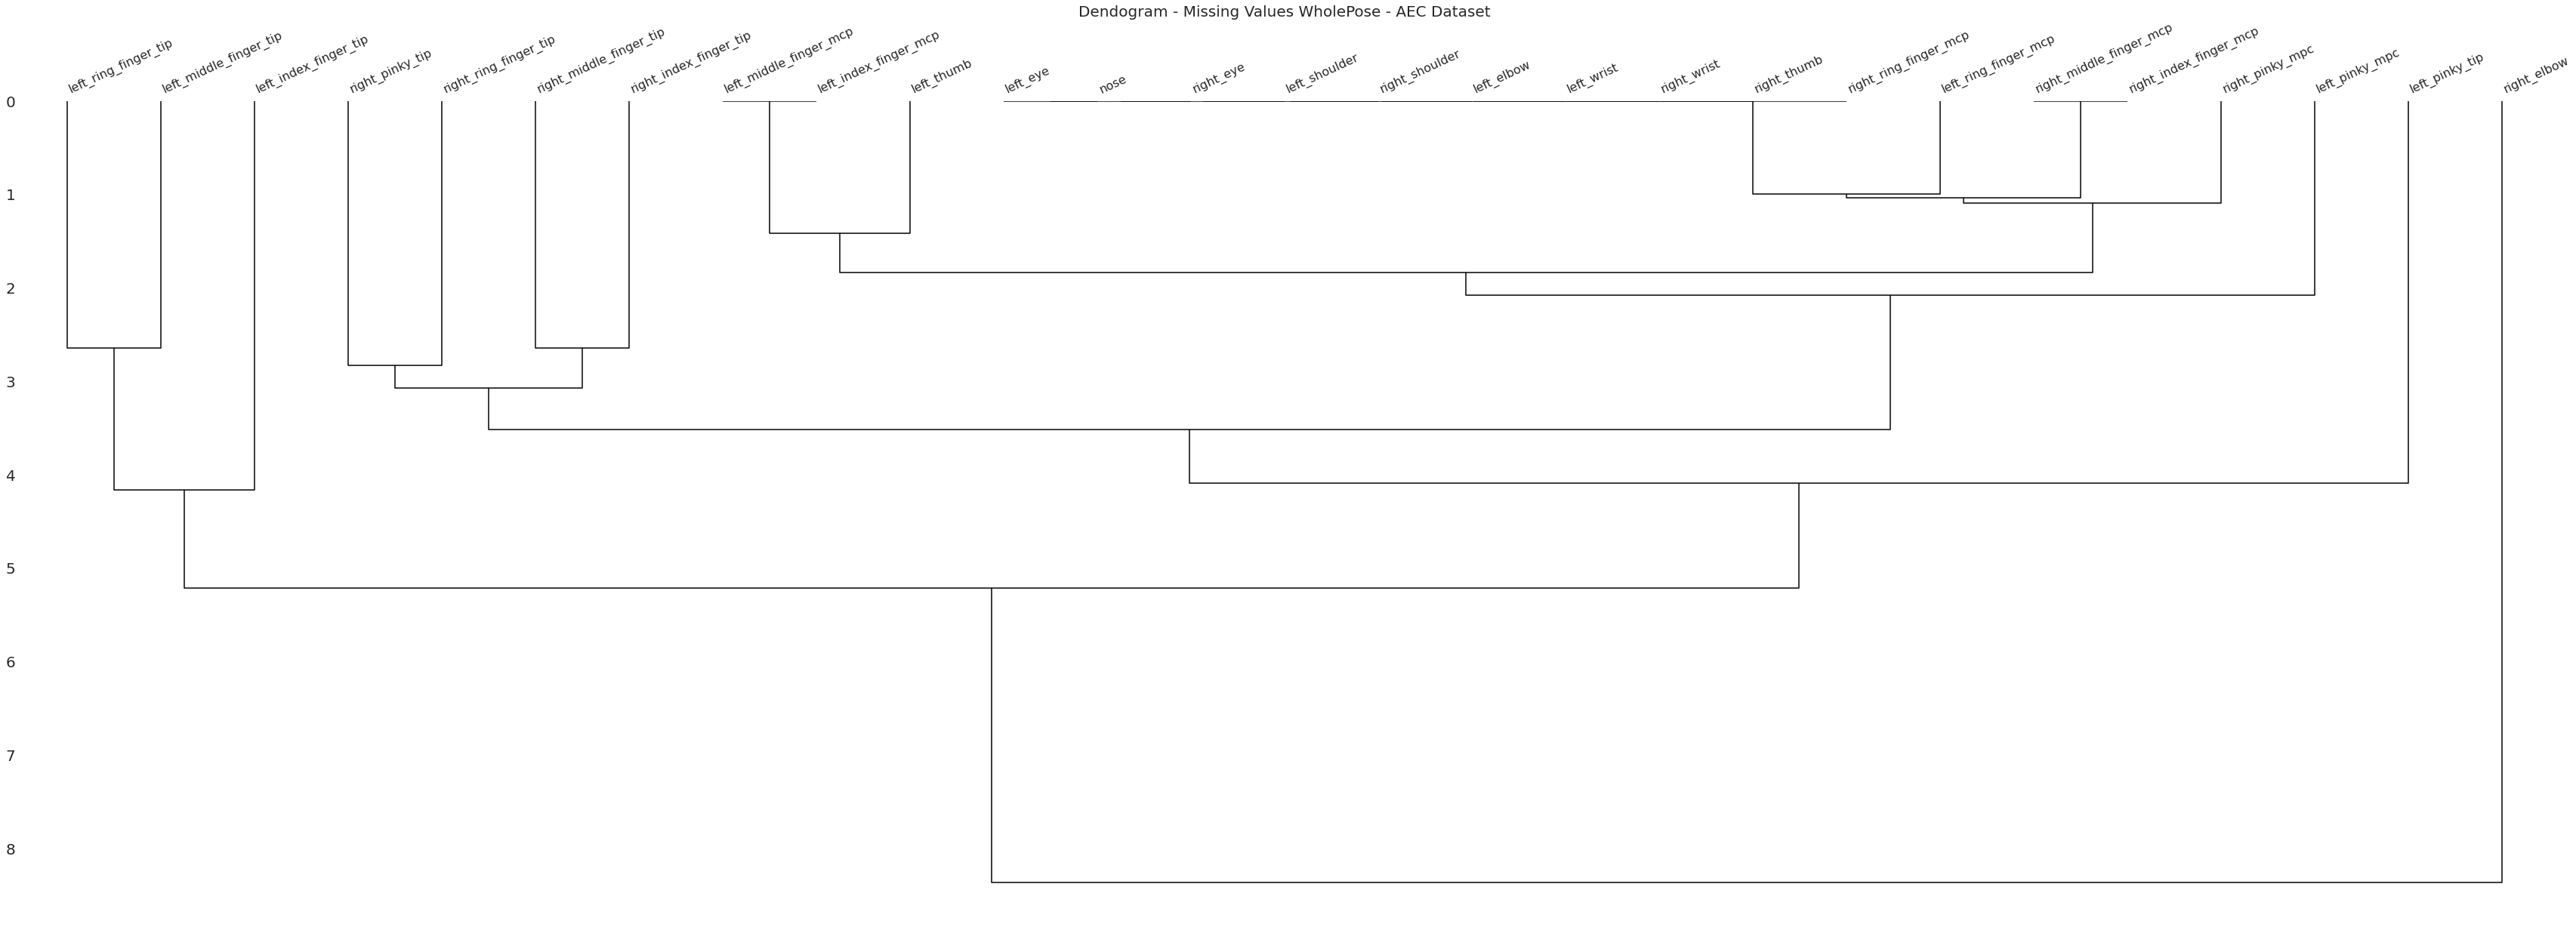

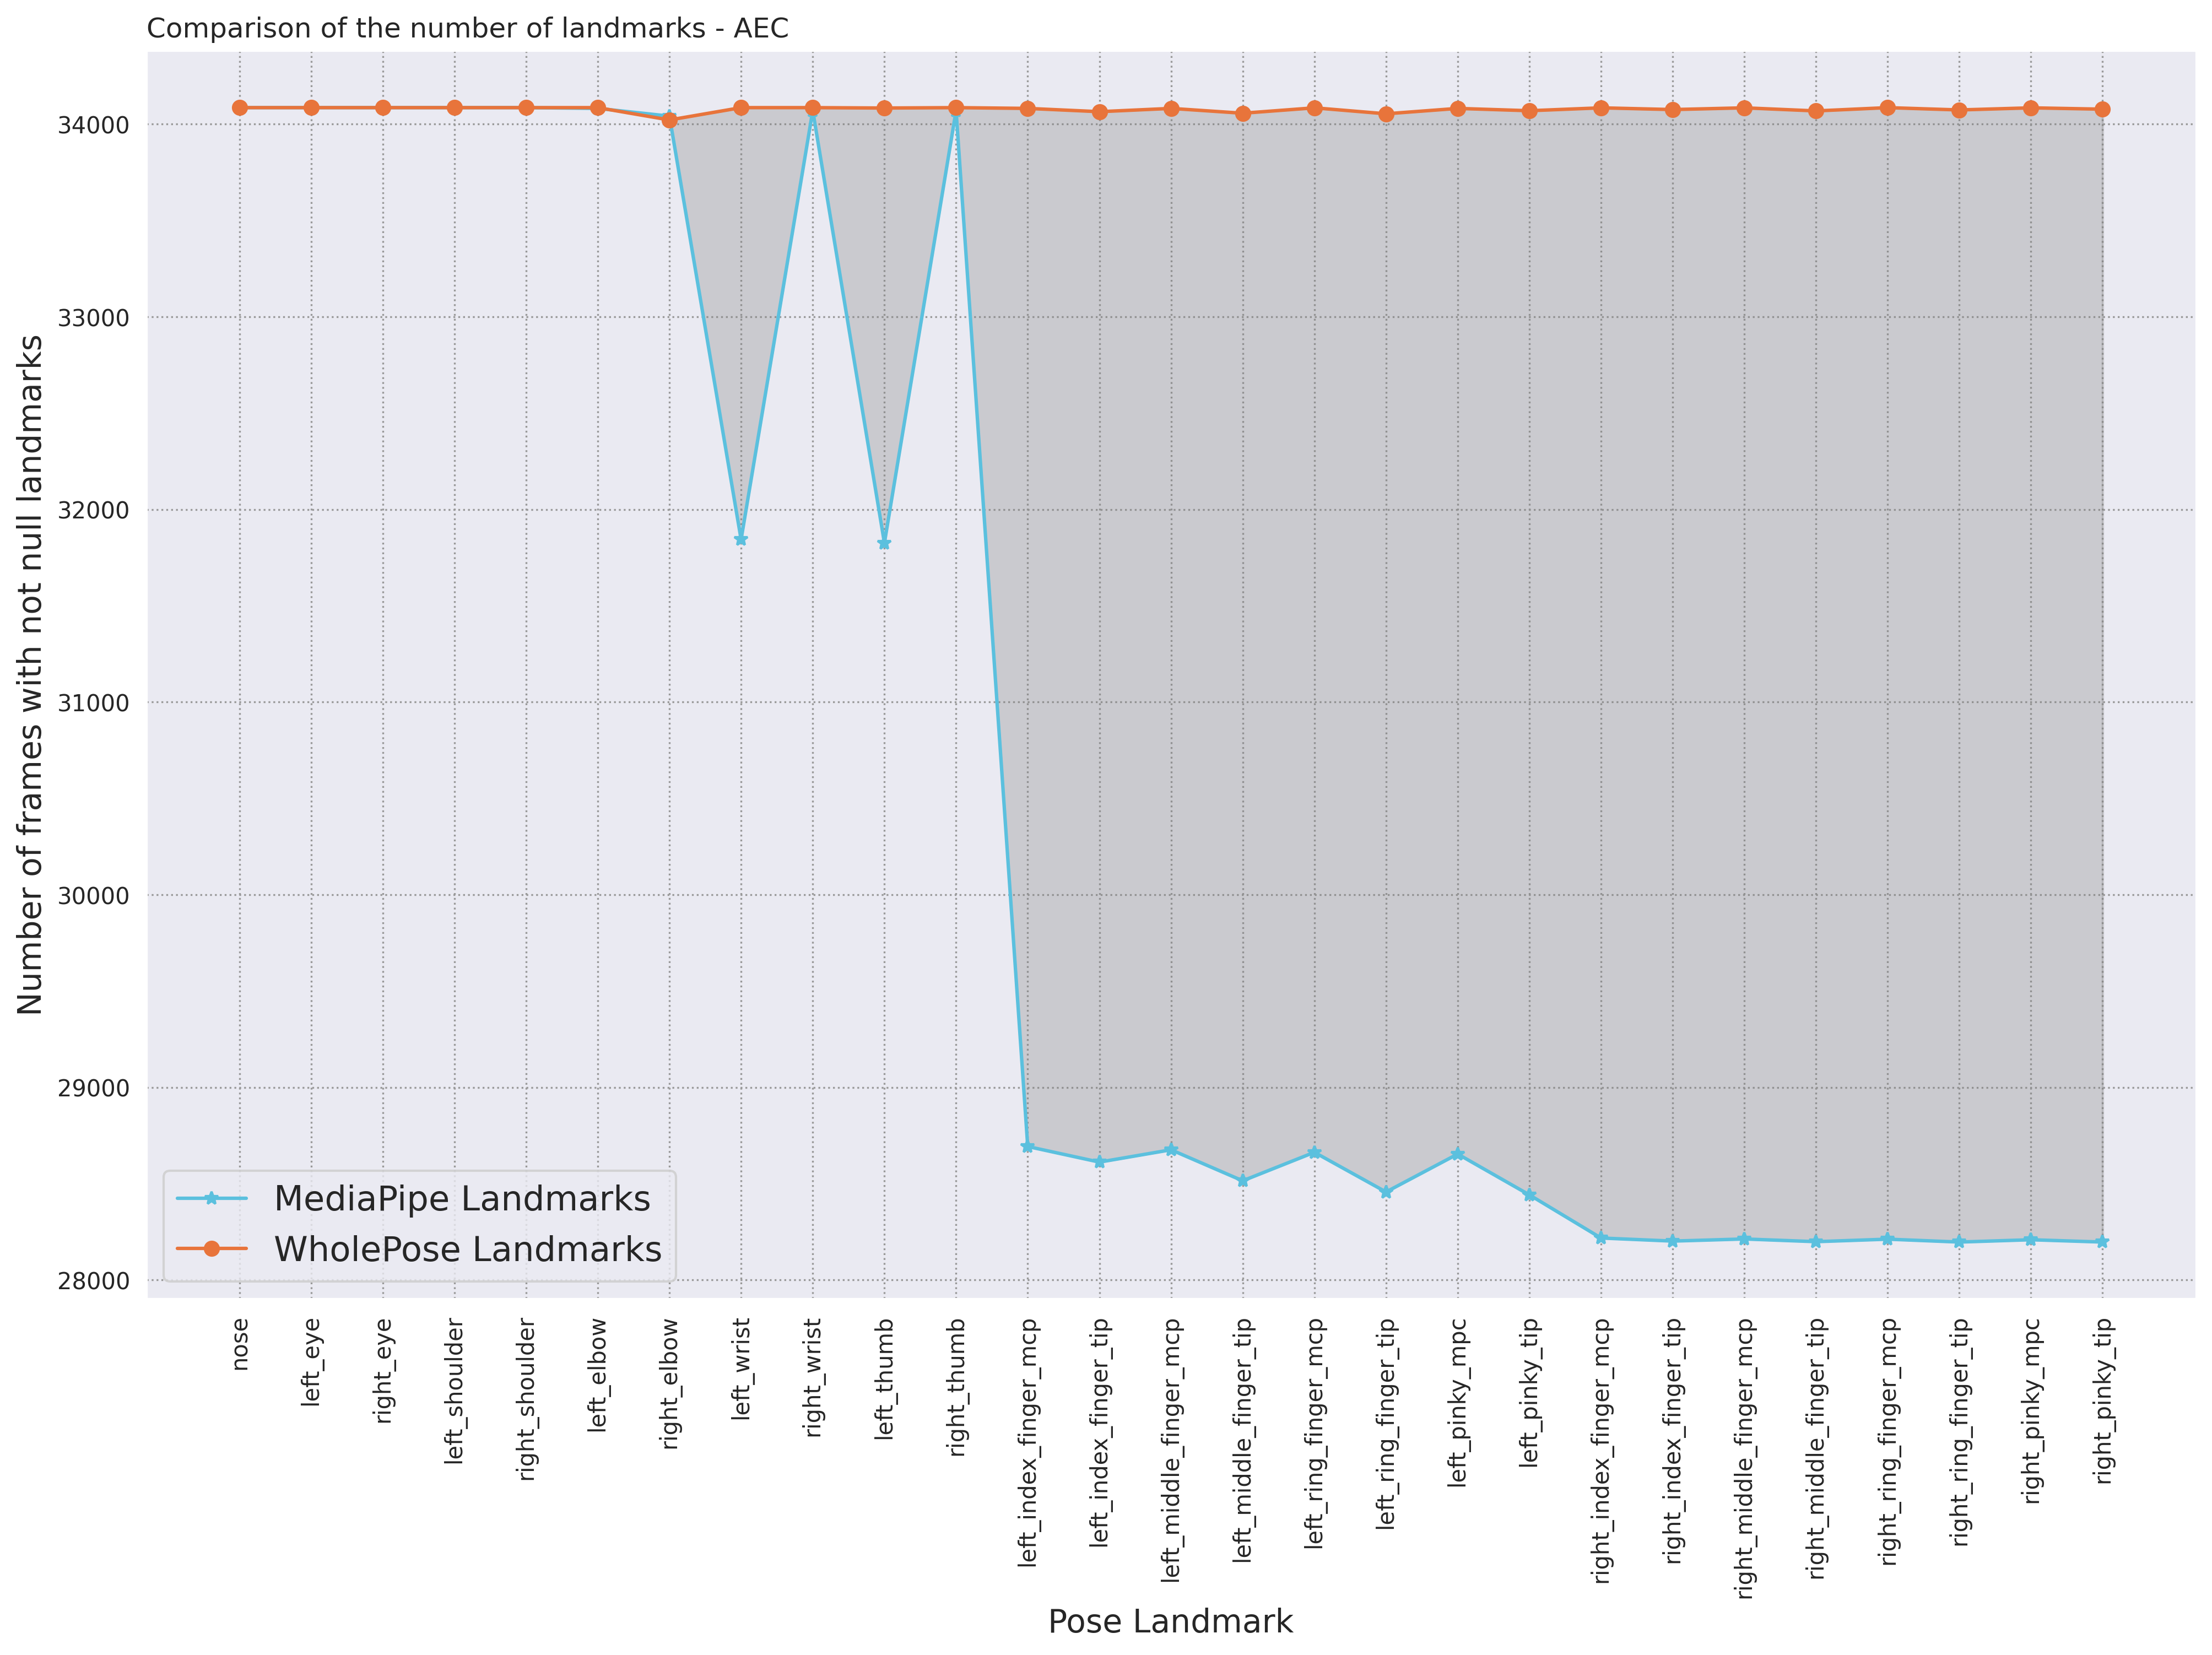

In [176]:
df_notna_lm = plot_all_missing_values_images(df_or,
                              df_flag_lm_orig,
                                  df_flag_lm,
                              list_landmarks_mp,
                                list_landmarks_coco_converted,
                              dict_rename_columns,
                                  dict_wp_rename_columns,
                               dataset="AEC")

In [162]:
df_notna_lm

,MediaPipe Landmarks,WholePose Landmarks
n_landmark,,
nose,73132,73140
left_eye,73132,73141
right_eye,73132,73141
left_shoulder,73132,73142
right_shoulder,73132,73142
left_elbow,73006,73142
right_elbow,73062,72681
left_wrist,65969,73081
right_wrist,70757,72525


# PUCP dataset

## Filtering incorrect data

In [99]:
#adding max landmark to wp dataset
df_pucp_wp_or_corr["n_landmark"] = df_pucp_wp_or_corr["n_landmark"] + max_landmark + 1
df_pucp_wp_or_corr.head(10)

,videoname,n_frame,n_landmark,x,y,class,out_range?
0,CERRAR-CORTINA_1655.mp4,0,543,0.441406,0.253906,CERRAR-CORTINA,False
1,CERRAR-CORTINA_1655.mp4,0,544,0.488281,0.222656,CERRAR-CORTINA,False
2,CERRAR-CORTINA_1655.mp4,0,545,0.402344,0.222656,CERRAR-CORTINA,False
3,CERRAR-CORTINA_1655.mp4,0,546,0.550781,0.253906,CERRAR-CORTINA,False
4,CERRAR-CORTINA_1655.mp4,0,547,0.363281,0.253906,CERRAR-CORTINA,False
5,CERRAR-CORTINA_1655.mp4,0,548,0.675781,0.519531,CERRAR-CORTINA,False
6,CERRAR-CORTINA_1655.mp4,0,549,0.277344,0.511719,CERRAR-CORTINA,False
7,CERRAR-CORTINA_1655.mp4,0,550,0.753906,0.800781,CERRAR-CORTINA,False
8,CERRAR-CORTINA_1655.mp4,0,551,0.113281,0.824219,CERRAR-CORTINA,False
9,CERRAR-CORTINA_1655.mp4,0,552,0.636719,0.667969,CERRAR-CORTINA,False


In [163]:
df_or = pd.concat([df_pucp_mp_or_corr[["videoname", "n_frame", "n_landmark",
                                "x", "y", "class"]],
                  df_pucp_wp_or_corr[["videoname", "n_frame", "n_landmark",
                                "x", "y", "class"]]
                  ]).reset_index(drop=True)
print(df_or.shape)
df_or.head()

(46884595, 6)


,videoname,n_frame,n_landmark,x,y,class
0,CERRAR-CORTINA_1655.mp4,0,0,0.467856,0.275306,CERRAR-CORTINA
1,CERRAR-CORTINA_1655.mp4,0,1,0.492731,0.231089,CERRAR-CORTINA
2,CERRAR-CORTINA_1655.mp4,0,2,0.510599,0.230034,CERRAR-CORTINA
3,CERRAR-CORTINA_1655.mp4,0,3,0.528634,0.228873,CERRAR-CORTINA
4,CERRAR-CORTINA_1655.mp4,0,4,0.441910,0.235417,CERRAR-CORTINA


In [164]:
print()
print("Original")
print(f"Shape {df_or.shape} - N classes", df_or["class"].nunique(), 
    " - Number of videos", df_or["videoname"].nunique())



Original
Shape (46884595, 6) - N classes 1082  - Number of videos 3682


## Filtering Landmarks

In [165]:
df_or, df_flag_lm_orig, df_flag_lm, df_flag_lm_v = filter_landmarks(df_or, list_landmarks_mp, list_landmarks_coco_converted, use_coco=True)


Use coco True

Filter: list of landmarks
Shape (1970321, 8) - N classes 1082  - Number of videos 3682

Filter: frames that have all landmarks
Shape (1934280, 8) - N classes 1082  - Number of videos 3682

Filter: videos which all frames have those landmarks
Shape (1719954, 8) - N classes 973  - Number of videos 3272


## Missing Values Analysis of MediaPipe Landmarks

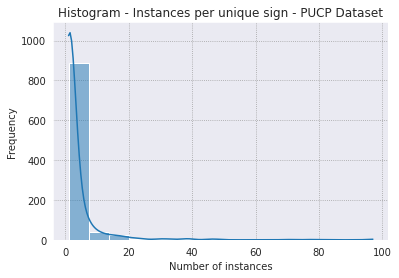

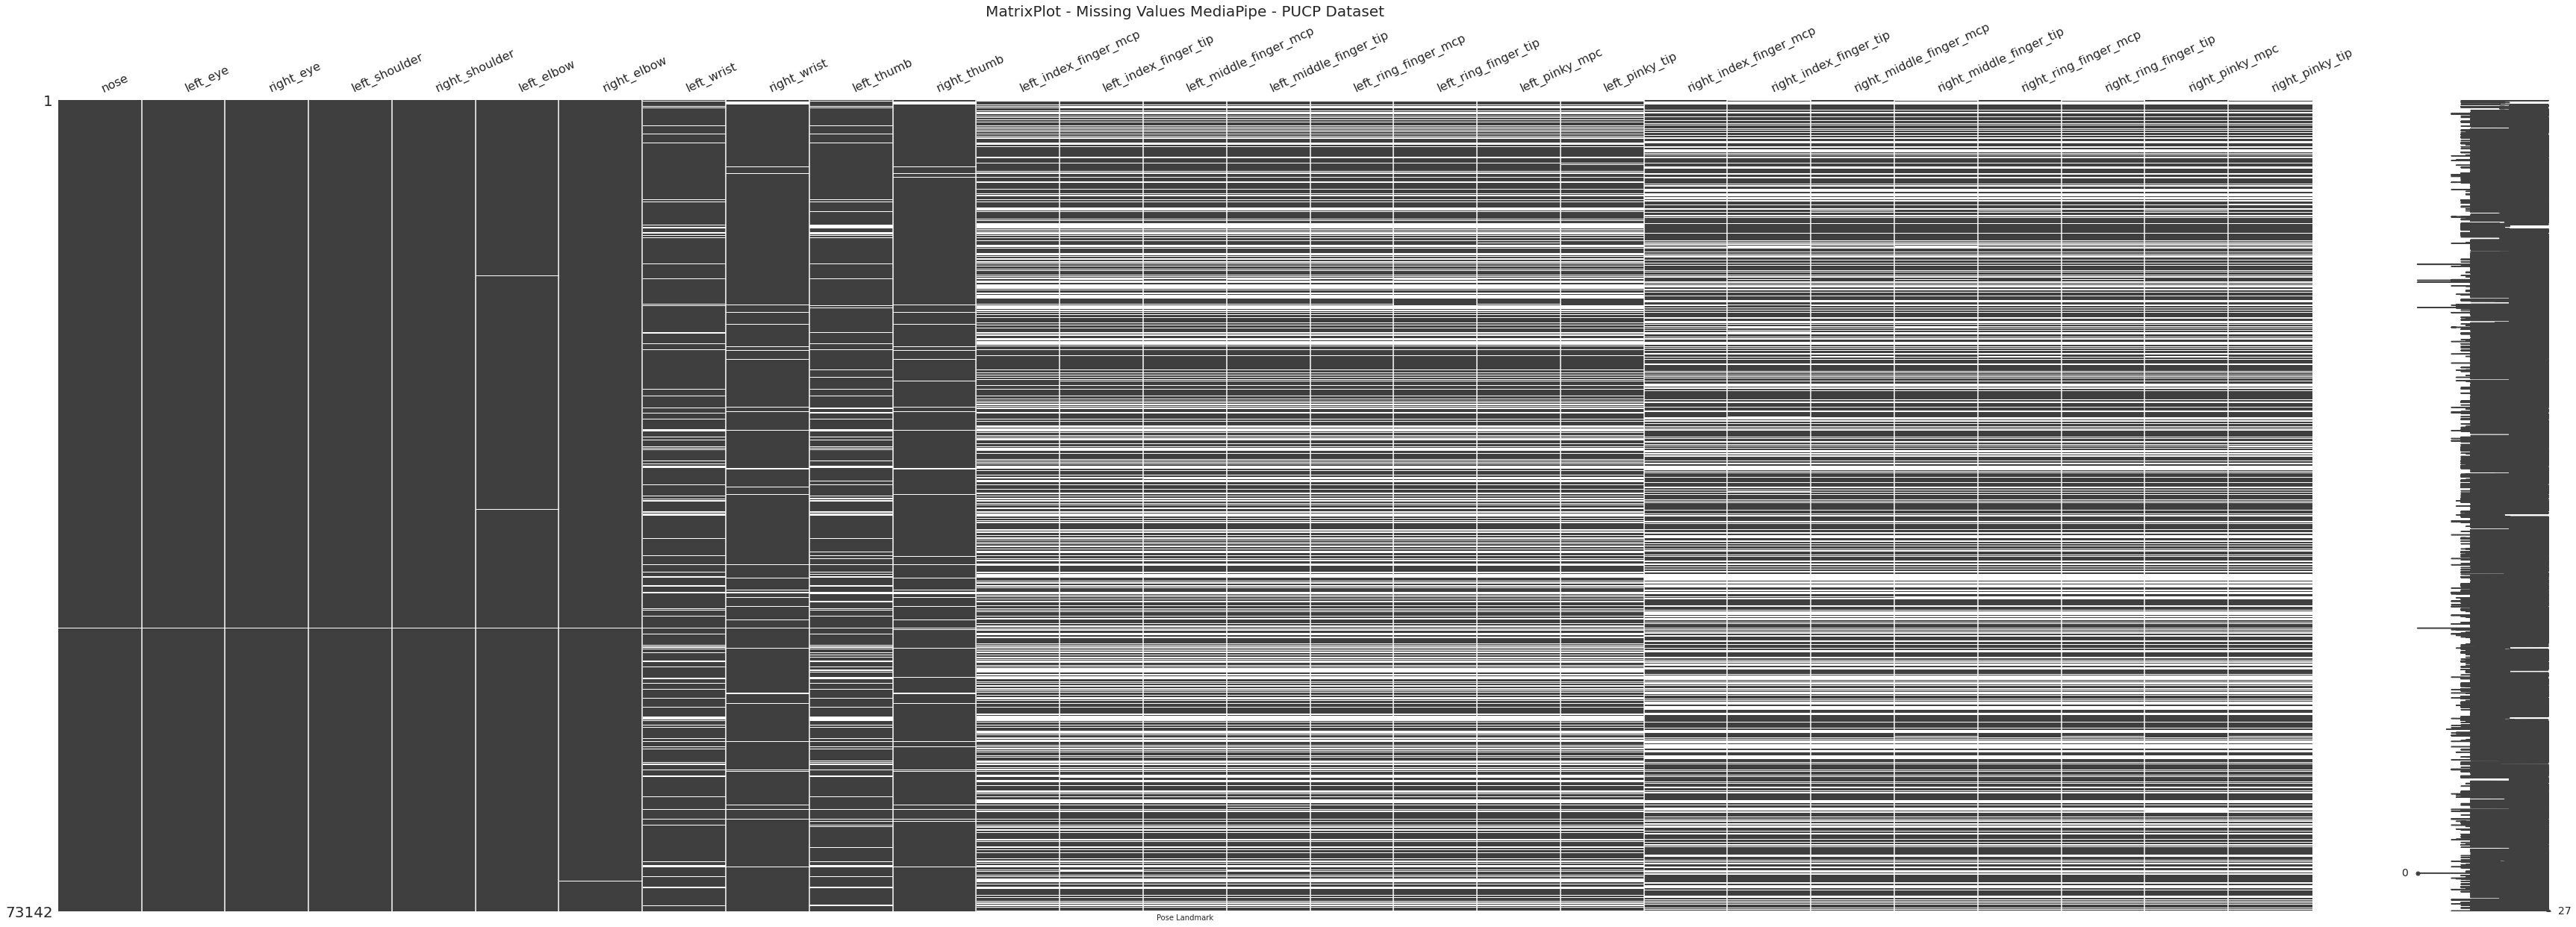

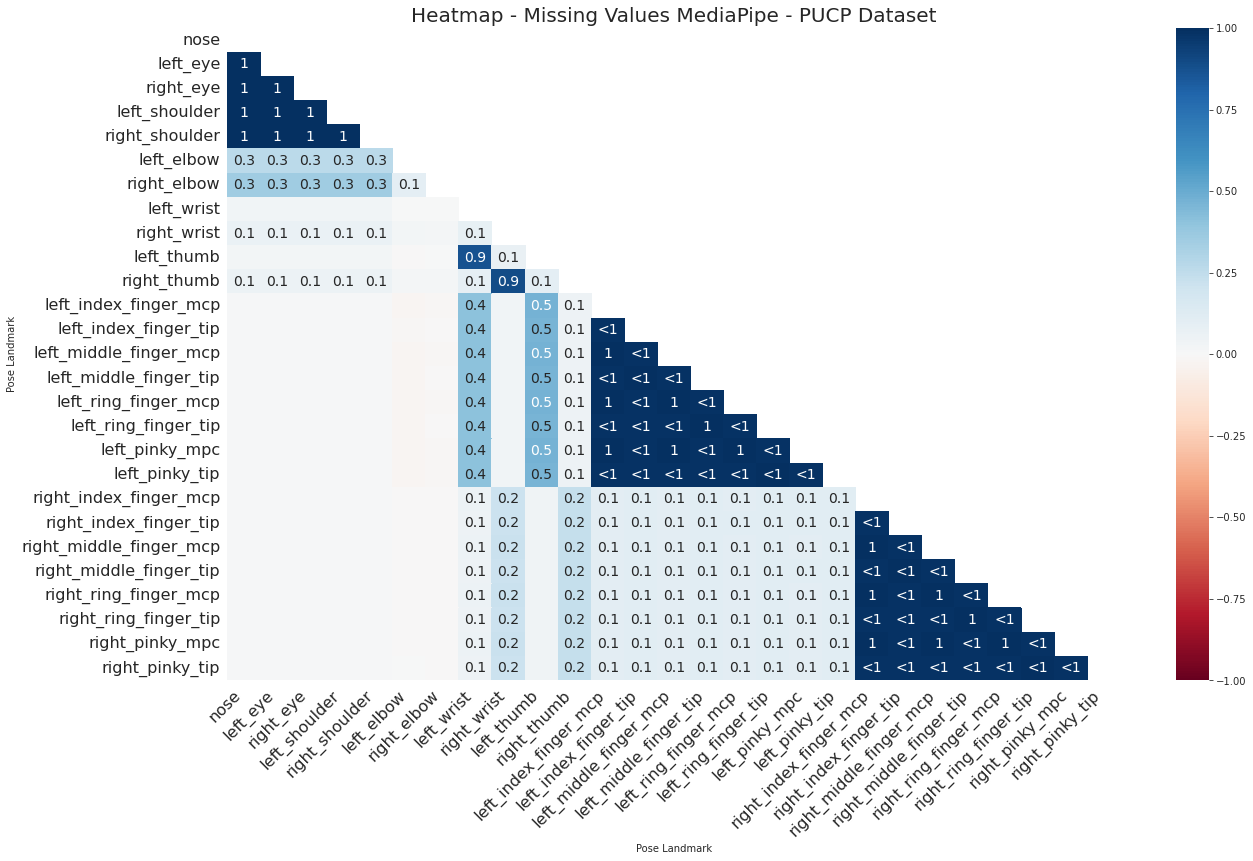

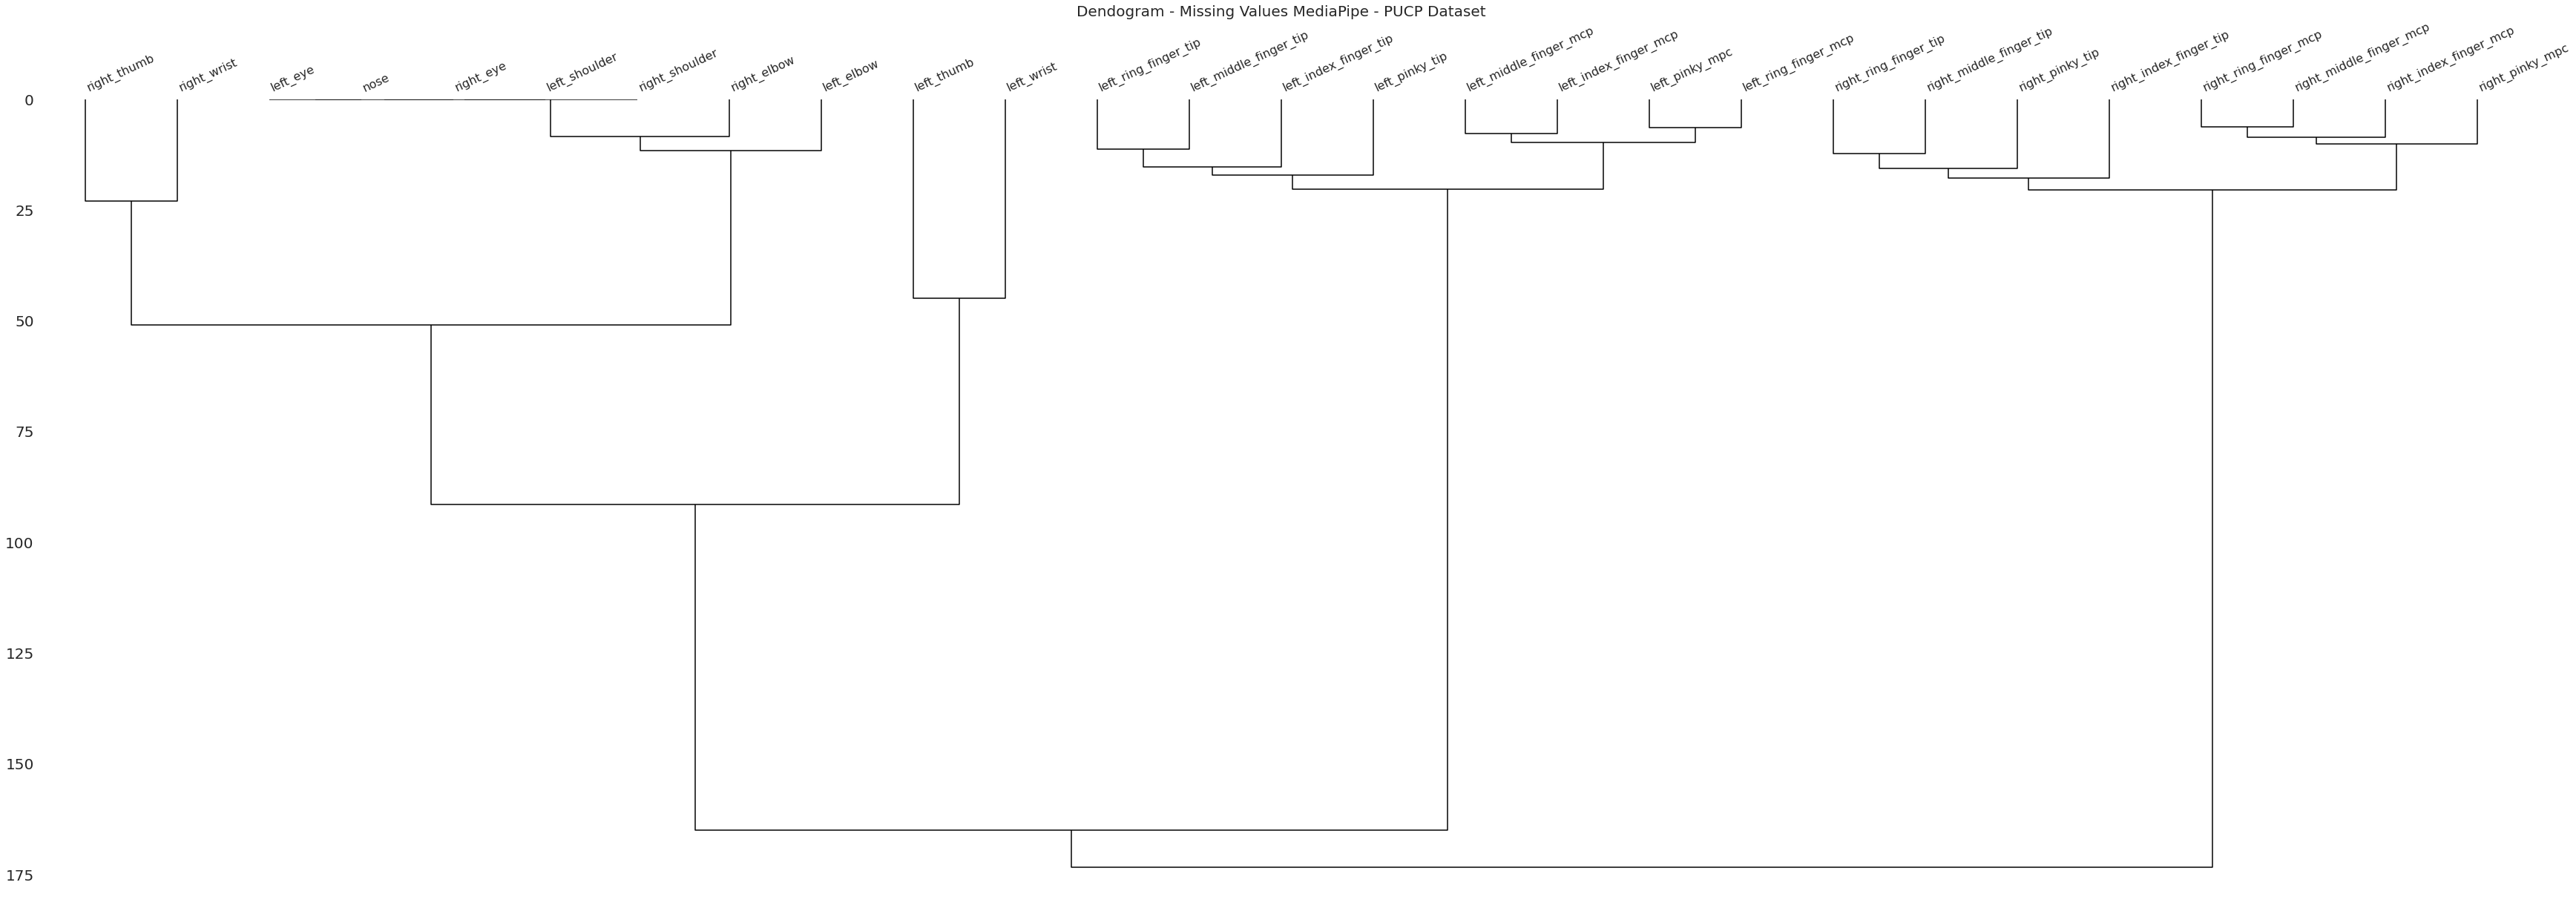

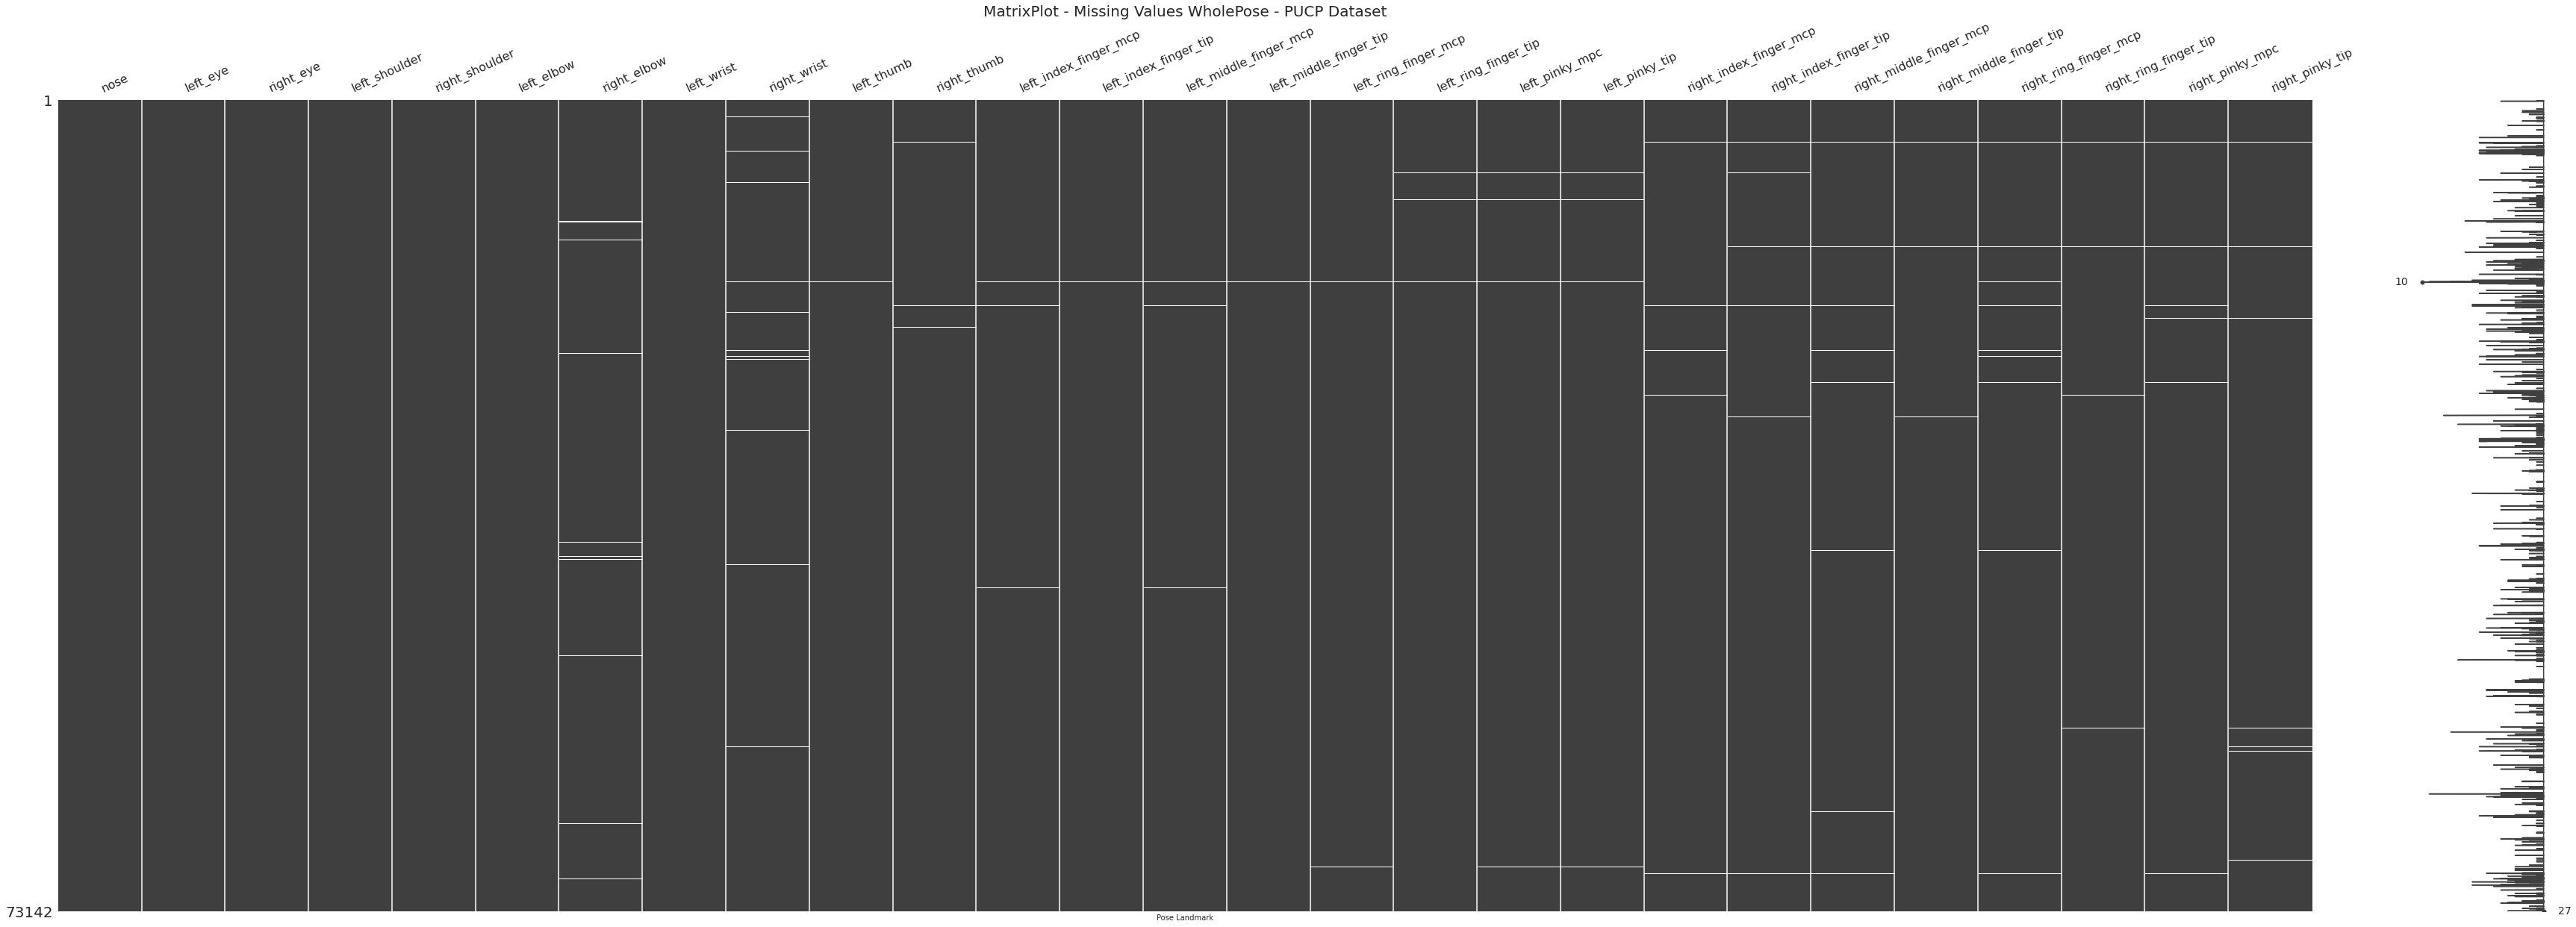

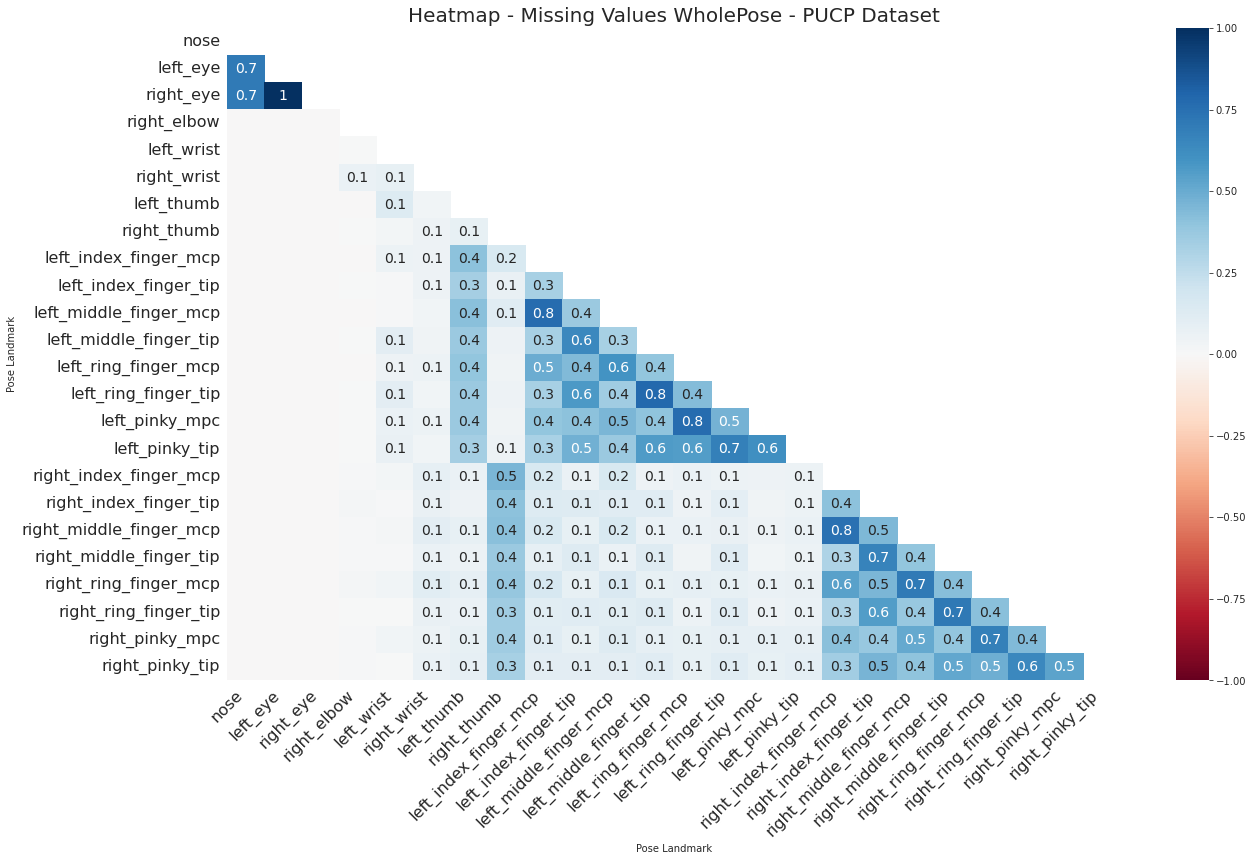

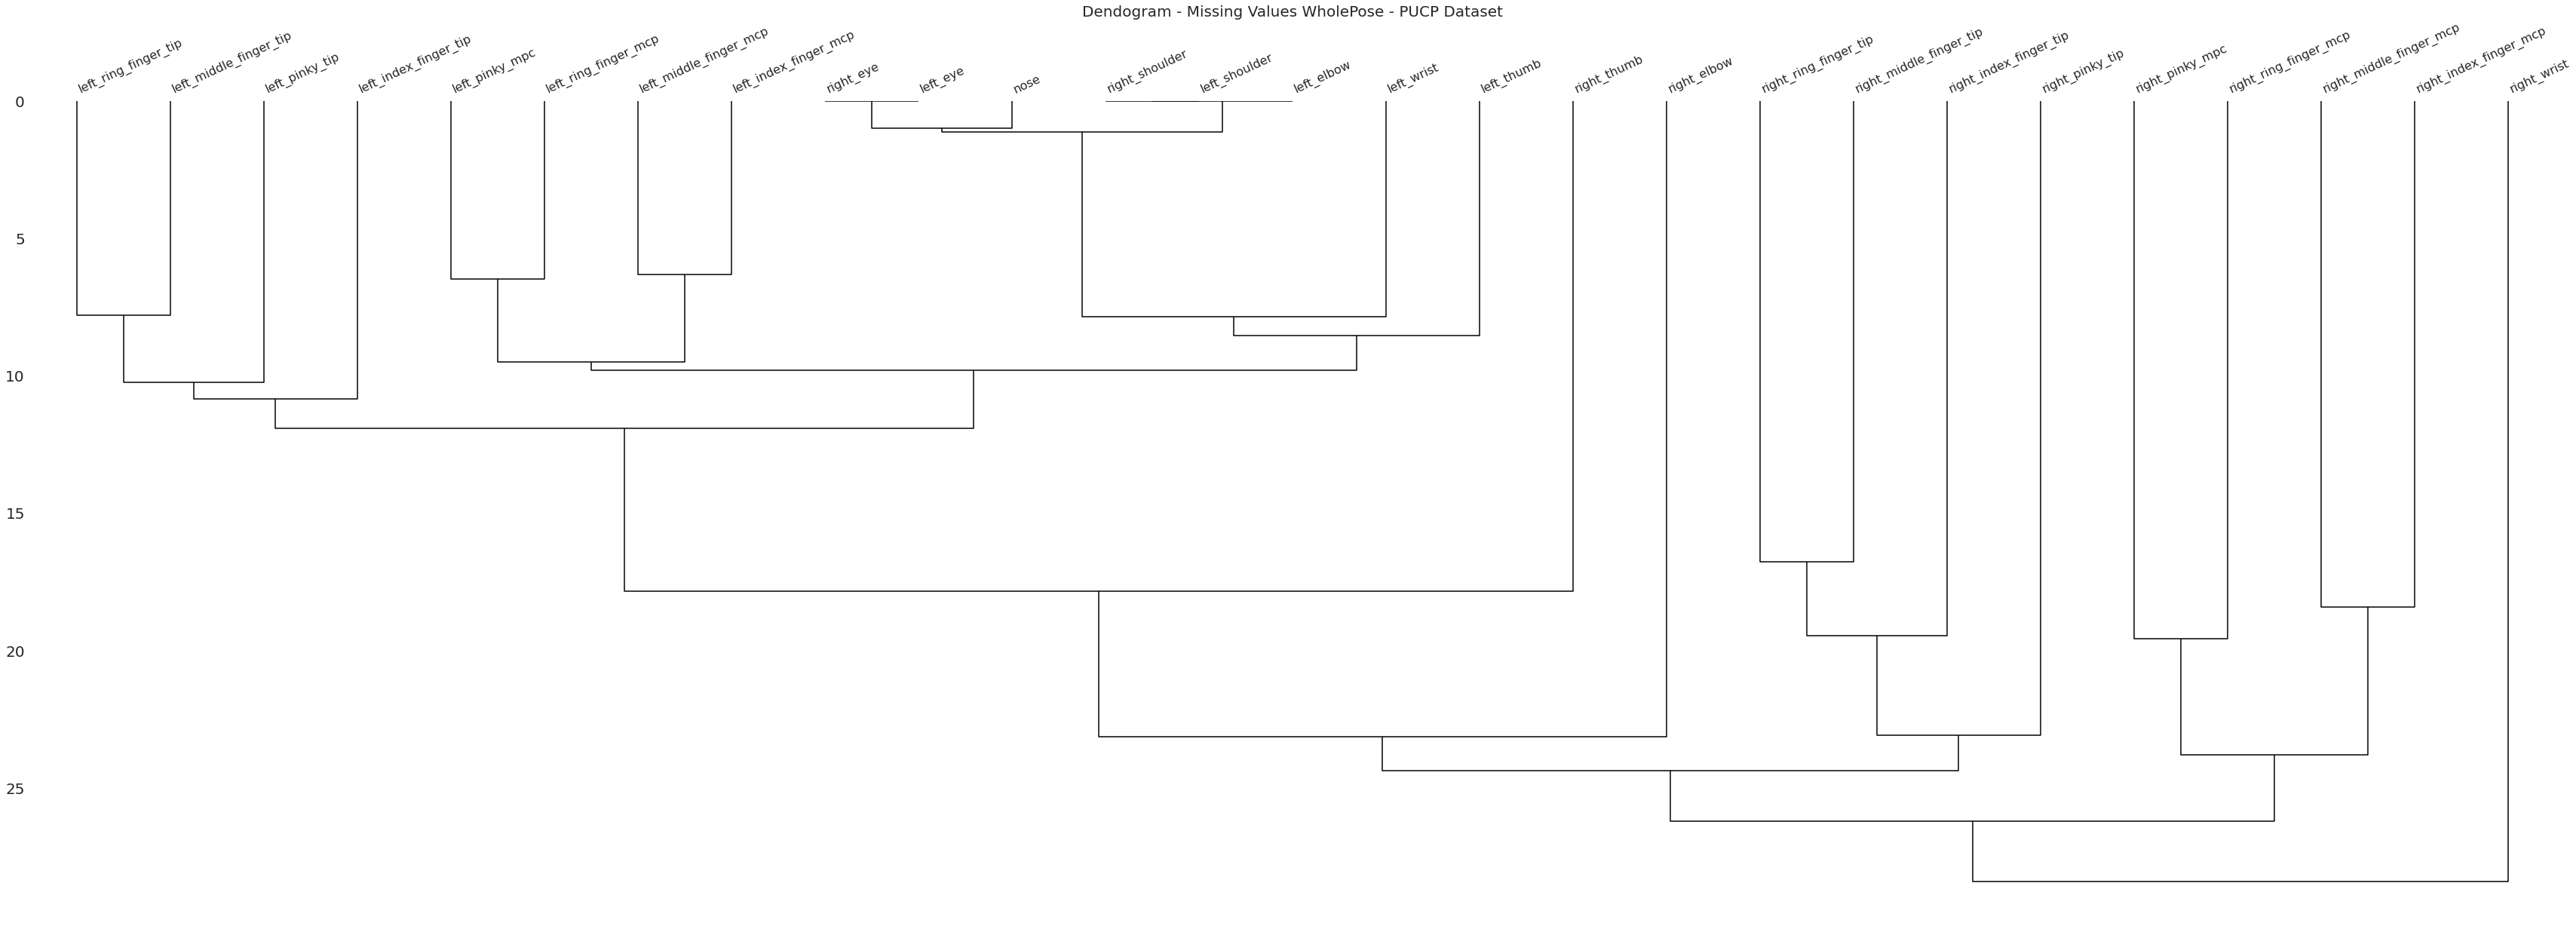

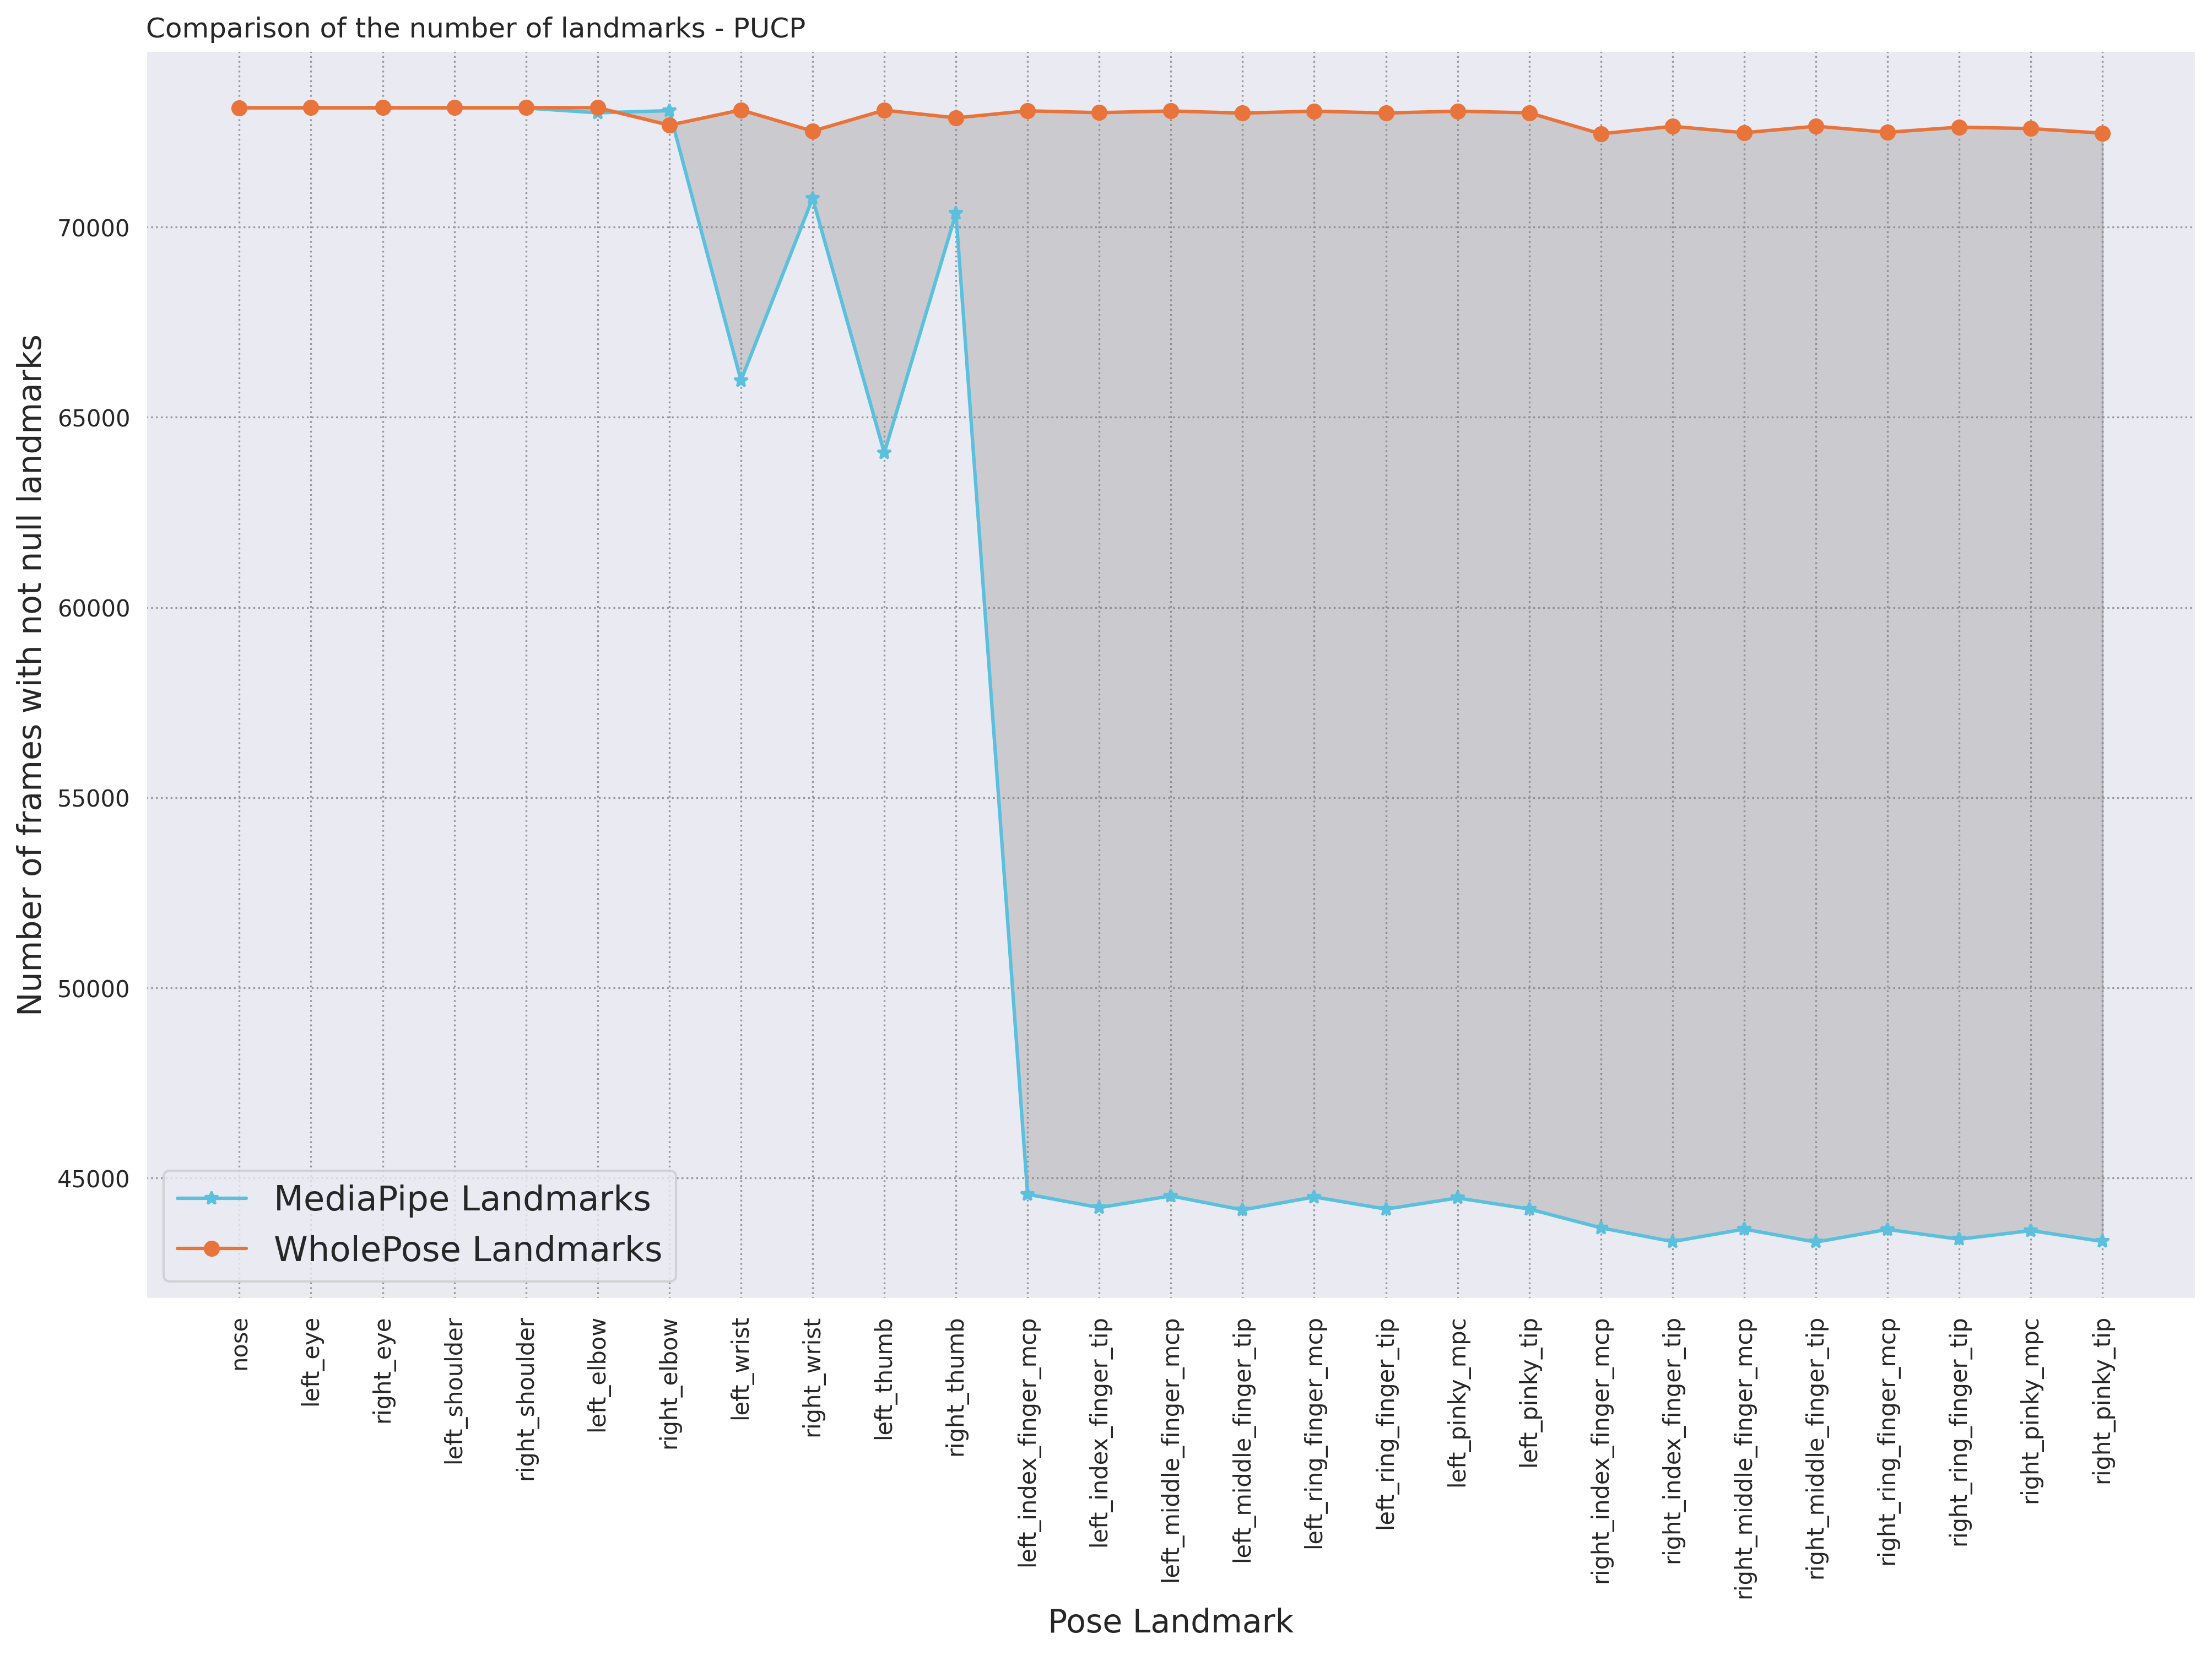

In [166]:
df_notna_lm = plot_all_missing_values_images(df_or,
                              df_flag_lm_orig,
                                  df_flag_lm,
                              list_landmarks_mp,
                                list_landmarks_coco_converted,
                              dict_rename_columns,
                                  dict_wp_rename_columns,
                               dataset="PUCP")